# IMPORTS


In [2]:
import inflection
import math 
import datetime
import pandas     as pd
import seaborn    as sns

from IPython.core.display  import HTML
from matplotlib.gridspec   import GridSpec
from IPython.display       import Image
from matplotlib            import pyplot as plt
from scipy                 import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder




## Helper functions


def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

jupyter_settings()

In [3]:
def cramer_v (x, y ): 
    cm = pd.crosstab (x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency (cm)[0]
    
    #eliminacao do bias
    chi2corr = max( 0, chi2 - (k-1) * (r-1) / (n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min (kcorr-1, rcorr-1 )))

def jupyter_settings():
    %matplotlib inline
    %pylab inline   
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    sns.set ()

In [5]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Loading data

In [6]:
df_sales_raw = pd.read_csv ('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv ('data/store.csv', low_memory = False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [7]:
df_raw.sample(2)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
587585,766,2,2014-01-21,6748,524,1,1,0,0,d,c,9820.0,NaN,NaN,0,NaN,NaN,NaN
734148,149,3,2013-09-11,6597,598,1,1,0,1,d,a,2610.0,7.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [8]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# PASSO 1. DESCRICAO DOS DADOS

In [9]:
df1 = df_raw.copy()

## Rename Columns

In [10]:
cols_old = [ 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
             'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore (x)

cols_new = map (snakecase, cols_old)

#rename
df1.columns = cols_new

In [11]:
# <notion> 
# inflection.underscore () - metodo para passar de KamelCase para snak_case 

# cols_old = [ 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
#              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
#             'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

# snakecase = lambda x: inflection.underscore (x)

# cols_new = map (snakecase, cols_old)

# #rename
# df1.columns = cols_new

## Data Dimensions

In [12]:
print ('Number of Rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of columns: 18


## Data Types

In [13]:
df1['date'] = pd.to_datetime( df1['date'] ) 
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Check NA

In [14]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NA

In [15]:
df1[ (df1['competition_open_since_month'].isna()) & (df1['competition_distance'].isna() ) ]

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
290,291,5,2015-07-31,10052,973,1,1,0,1,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,5,2015-07-31,6306,540,1,1,0,1,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,5,2015-07-31,6000,466,1,1,0,0,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"
1405,291,4,2015-07-30,9030,883,1,1,0,1,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
1736,622,4,2015-07-30,5412,406,1,1,0,1,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015601,622,3,2013-01-02,4080,451,1,0,0,1,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
1015858,879,3,2013-01-02,3077,326,1,0,0,1,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"
1016385,291,2,2013-01-01,0,0,0,0,a,1,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
1016716,622,2,2013-01-01,0,0,0,0,a,1,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN


In [16]:
df1['competition_distance'].max()

75860.0

In [17]:
# competition_distance   
#     !presume-se: se a distancia é muito grande, nao ha competidor proximo. 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)


# competition_open_since_month    
#     !presume-se: se estiver na, e 'competition_distance' not null, considera-se a 'date', ja que nao faz sentido existir 
#         um competidor proximo que nao tenha inaugurado a loja ainda
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis =1)


# competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis =1)


# promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis =1)

# promo2_since_year 
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis =1)

# promo_interval    
month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'].fillna(0, inplace = True )

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [18]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [19]:
# <notion> 
# math.isnan () - metodo booleano para identificar os NA

# df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)


## Change Dtypes

obs: após realizar alteracoes substanciais nos dados, é importante verificar os tipos

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [21]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')

df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')

df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## Descriptive Statical 

In [22]:
num_attributes = df1.select_dtypes ( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes ( exclude=['int64','float64'] )

### Numerical Attributes

In [23]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat ( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes','min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance', ylabel='Count'>

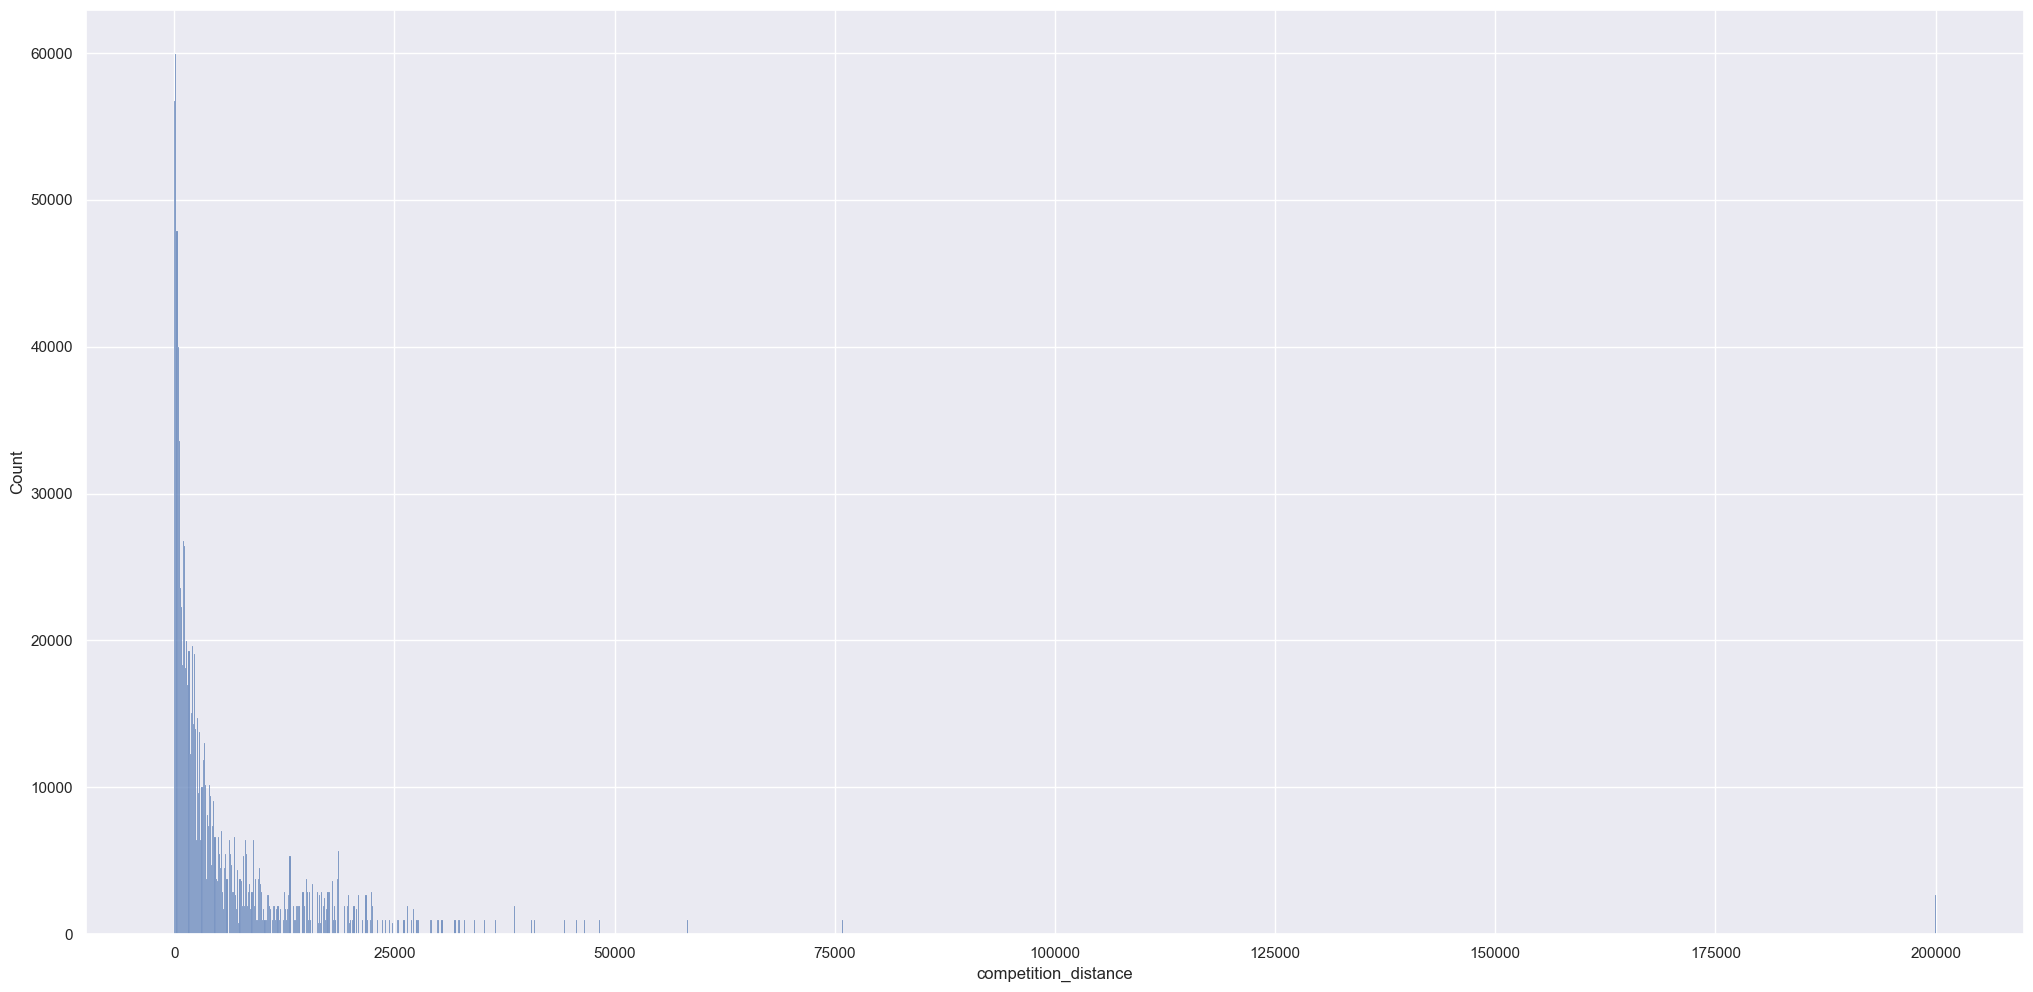

In [24]:
# plotando a coluna 'competition_distance' para estudar melhor o fenomeno visualmente
sns.histplot ( df1['competition_distance'] )

### Categorical Attributes

In [25]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

date              942
state_holiday       4
store_type          4
assortment          3
promo_interval      4
month_map          12
dtype: int64

In [26]:
df1[df1['state_holiday']=='0']['sales'].mean()

5947.48389255688

In [27]:
#aqui considerou-se os feriados, e tambem as vendas = 0, portanto o grafico trouxe todos pontos !=0 como outliers 
# sns.boxplot (x = 'state_holiday' , y = 'sales' , data = df1)

<AxesSubplot:xlabel='assortment', ylabel='sales'>

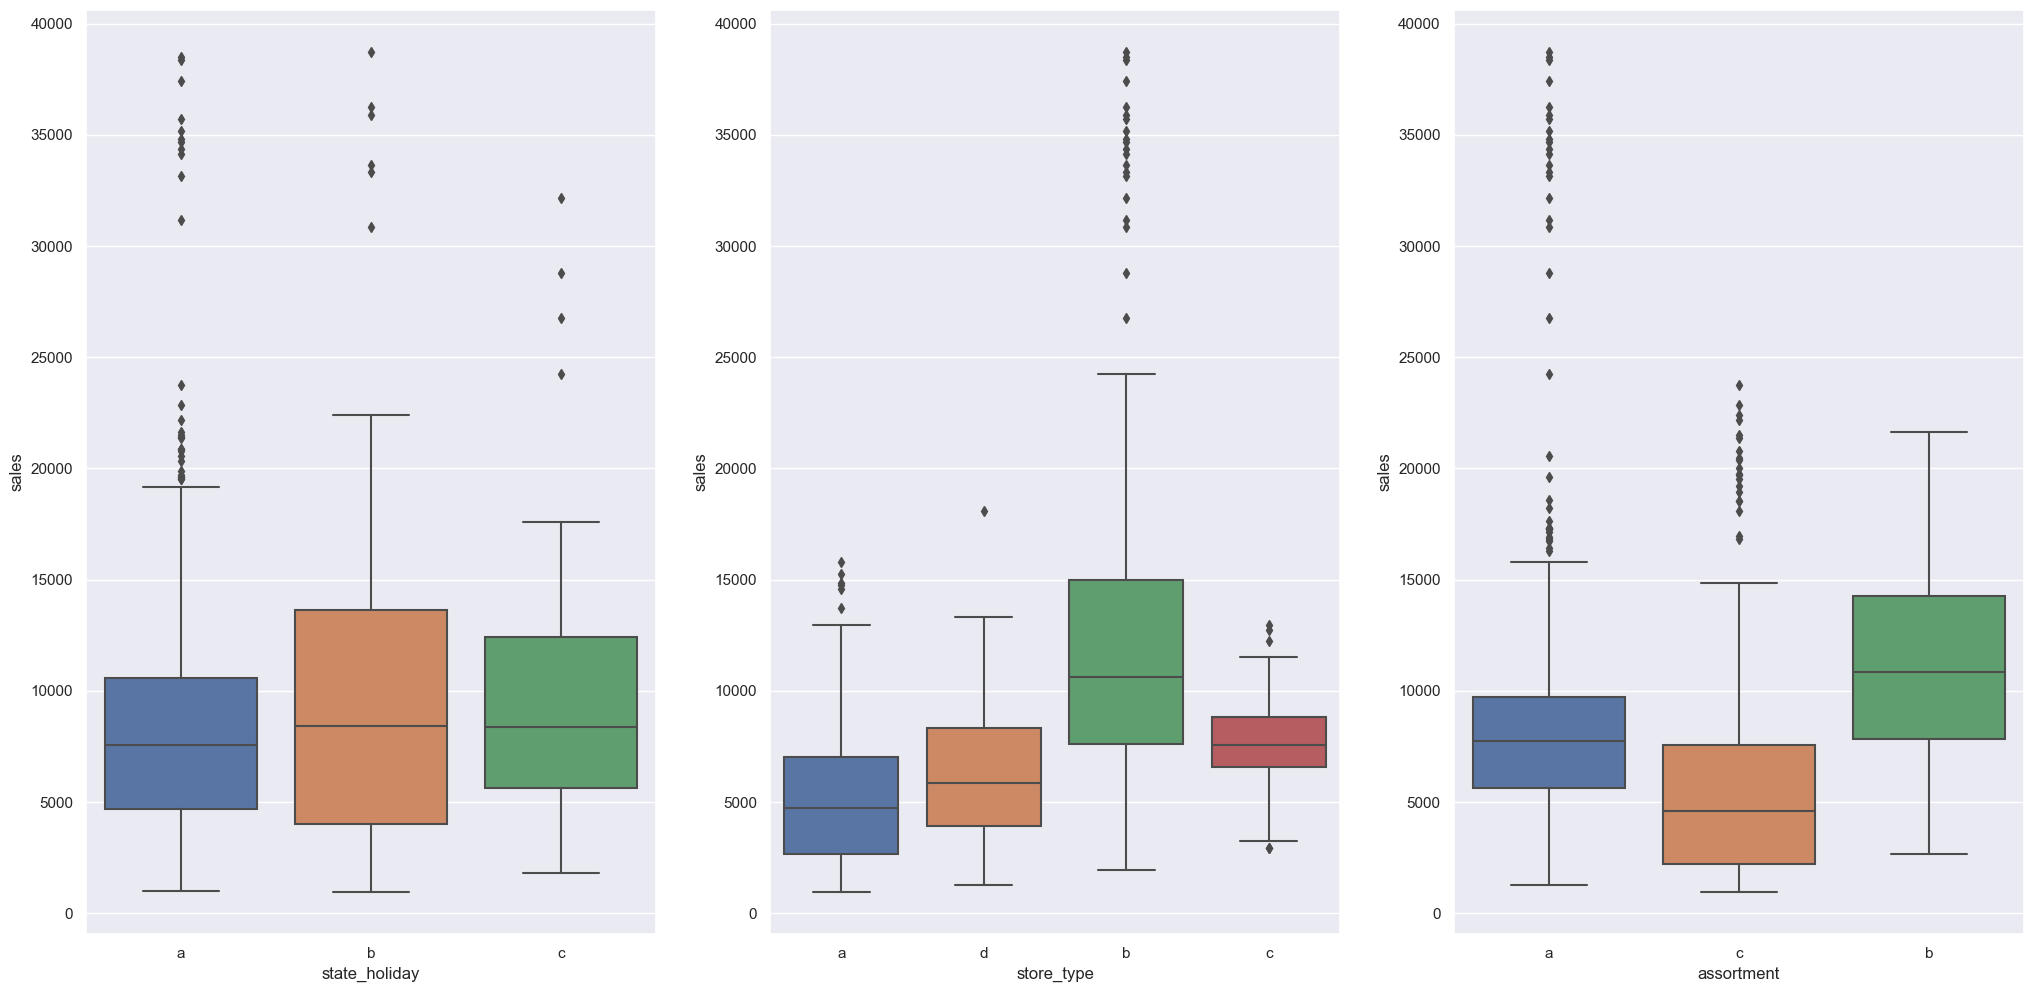

In [28]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]

plt.subplot (1, 3, 1)
sns.boxplot (x = 'state_holiday' , y = 'sales' , data = aux1)

plt.subplot (1, 3, 2)
sns.boxplot (x = 'store_type' , y = 'sales' , data = aux1)

plt.subplot (1, 3, 3)
sns.boxplot (x = 'assortment' , y = 'sales' , data = aux1)

# PASSO 2. FEATURE ENGINEERING

In [29]:
df2 = df1.copy ()

## Mapa mental de hipoteses

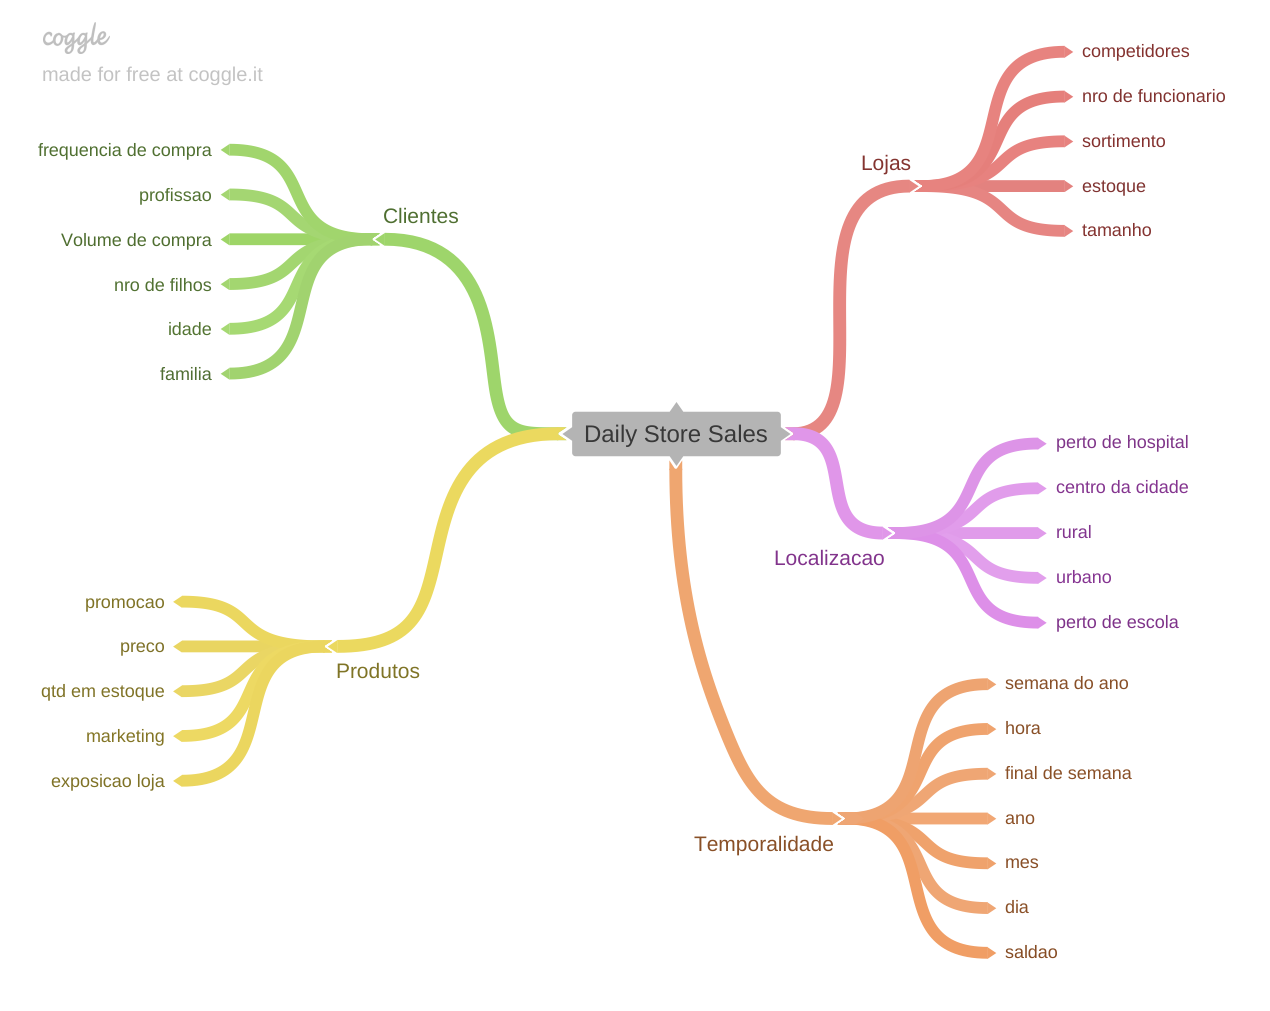

In [30]:
Image ('img/MindMapHypothesis.png')

## Criacao das hipoteses

### Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.



### Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### Lista Final de Hipoteses 

obs: priorizar com base na disponibilidade atual do dado

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.


### Feature Engineering

In [32]:
# year
df2['year'] = df2['date'].dt.year

# month 
df2['month'] = df2['date'].dt.month

# # day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )
df2.head()

# competition since
#     |intervalo entre inicio da competicao até date
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1 ), axis=1 )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply( lambda x: x.days ).astype ( int ) 

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype ( str ) + '-' + df2['promo2_since_week'].astype ( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta ( days=7 ) )
df2['promo_time_week'] = ( (df2['date'] - df2['promo_since'])/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


In [33]:
# <notion> 

# .dt.isocalendar().week - atributo para extrair apenas a semana do ano
    # df2['week_of_year'] = df2['date'].dt.isocalendar().week

# datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta ( days=7 ) - para calcular a diferenca 
# em semanas de uma string de data no formato %Y-%W-%w
#     datetime.timedelta ( days=7 ) - é como se gerasse uma unidade que contem 7 dias
    # # promo since
    # df2['promo_since'] = df2['promo2_since_year'].astype ( str ) + '-' + df2['promo2_since_week'].astype ( str )
    # df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta ( days=7 ) )
    # df2['promo_time_week'] = ( (df2['date'] - df2['promo_since'])/7 ).apply( lambda x: x.days ).astype( int )

In [34]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# PASSO 3. FILTRAGEM DAS VARIAVEIS

In [35]:
df3 = df2.copy()

In [36]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## Filtragem das linhas
obs: fazer a filtragem das linhas primeiro, pode fazer dimunuir o dataset, o que melhora performance

In [37]:
df3 = df3[ (df3['open'] != 0) &  (df3['sales'] > 0) ]

# open: quando igual a zero, a loja esta fechada, e nao tem venda, nao gera nenhum aprendizado pro modelo 
# sales: mesmo caso de open

## Selecao das colunas

In [38]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop( cols_drop, axis = 1 )


# customers: como nao se tem uma previsao de quantos clientes terao em 6 semanas, nao se tera esse input no modelo, 
#     entao é preciso filtrar essa variavel, por conta de uma restricao de negocio
# open: dado que filtrou-se os dias fechados, essa coluna nao é mais necessaria
# promo_interval e month_map: features ja foram derivadas
                 

In [39]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# PASSSO 4. ANALISE EXPLORATORIA DE DADOS

In [40]:
df4 = df3.copy()

## Analise Univariada

### Response Variable

Para melhor acuracia dos modelos, os dados precisam estar o mais normalizados possivel, aí pode se valer de algumas **transformacoes**, por exemplo aplicar a escala logaritimica 

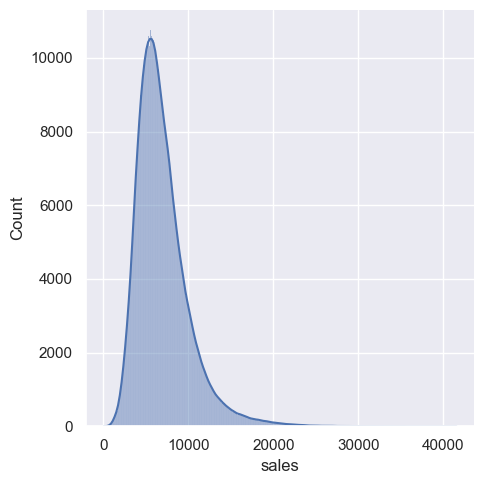

In [41]:
sns.displot (df4['sales'], kde=True)

### Numerical Variable

In [42]:
num_attributes

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,0,0,0,0,1,1900.0,6,2014,1,31,2013,1
1017205,1112,2,0,0,0,0,1,1880.0,4,2006,0,1,2013,0
1017206,1113,2,0,0,0,0,1,9260.0,1,2013,0,1,2013,0
1017207,1114,2,0,0,0,0,1,870.0,1,2013,0,1,2013,0


array([[<AxesSubplot:title={'center':'store'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'sales'}>,
        <AxesSubplot:title={'center':'customers'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'promo'}>,
        <AxesSubplot:title={'center':'school_holiday'}>,
        <AxesSubplot:title={'center':'competition_distance'}>],
       [<AxesSubplot:title={'center':'competition_open_since_month'}>,
        <AxesSubplot:title={'center':'competition_open_since_year'}>,
        <AxesSubplot:title={'center':'promo2'}>,
        <AxesSubplot:title={'center':'promo2_since_week'}>],
       [<AxesSubplot:title={'center':'promo2_since_year'}>,
        <AxesSubplot:title={'center':'is_promo'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

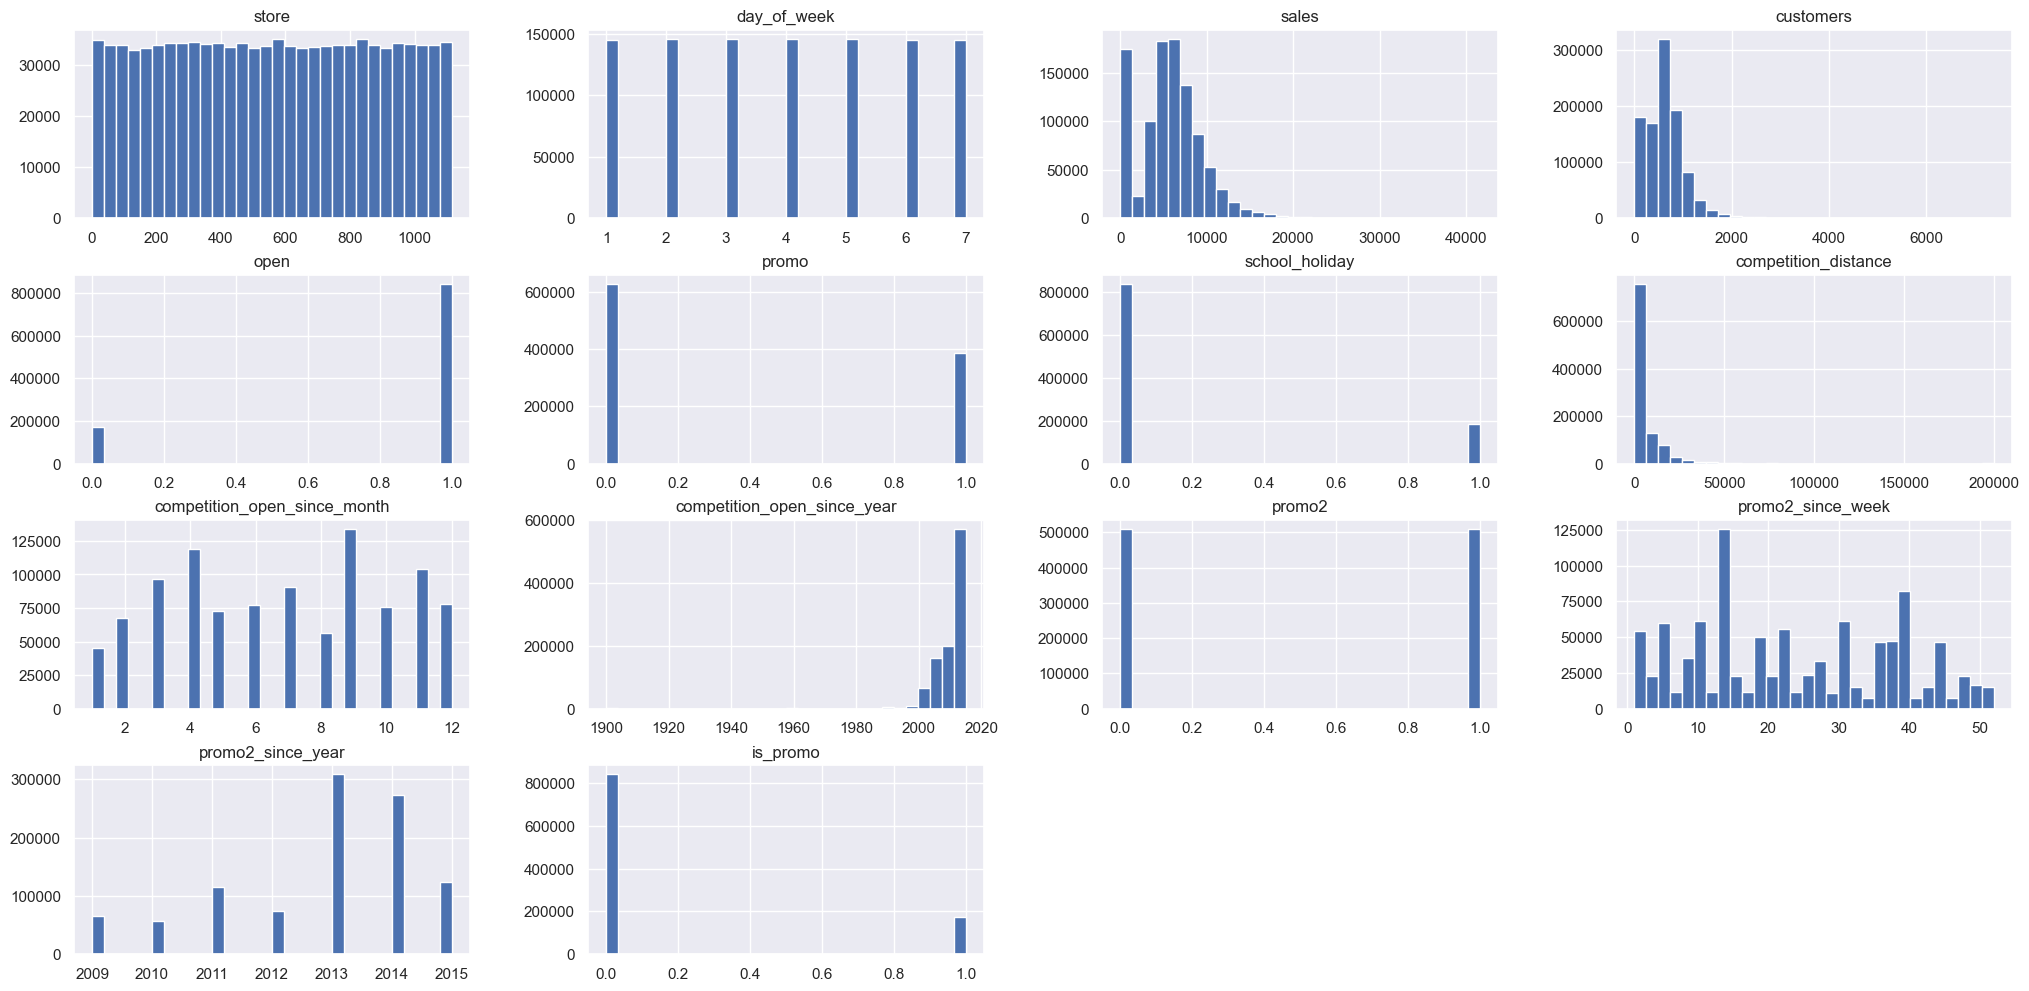

In [148]:
num_attributes.hist( bins=30 )



### Categorical Variable

In [44]:
cat_attributes.head()

,date,state_holiday,store_type,assortment,promo_interval,month_map
0,2015-07-31,0,c,a,0,Jul
1,2015-07-31,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,2015-07-31,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,2015-07-31,0,c,c,0,Jul
4,2015-07-31,0,a,a,0,Jul


In [45]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

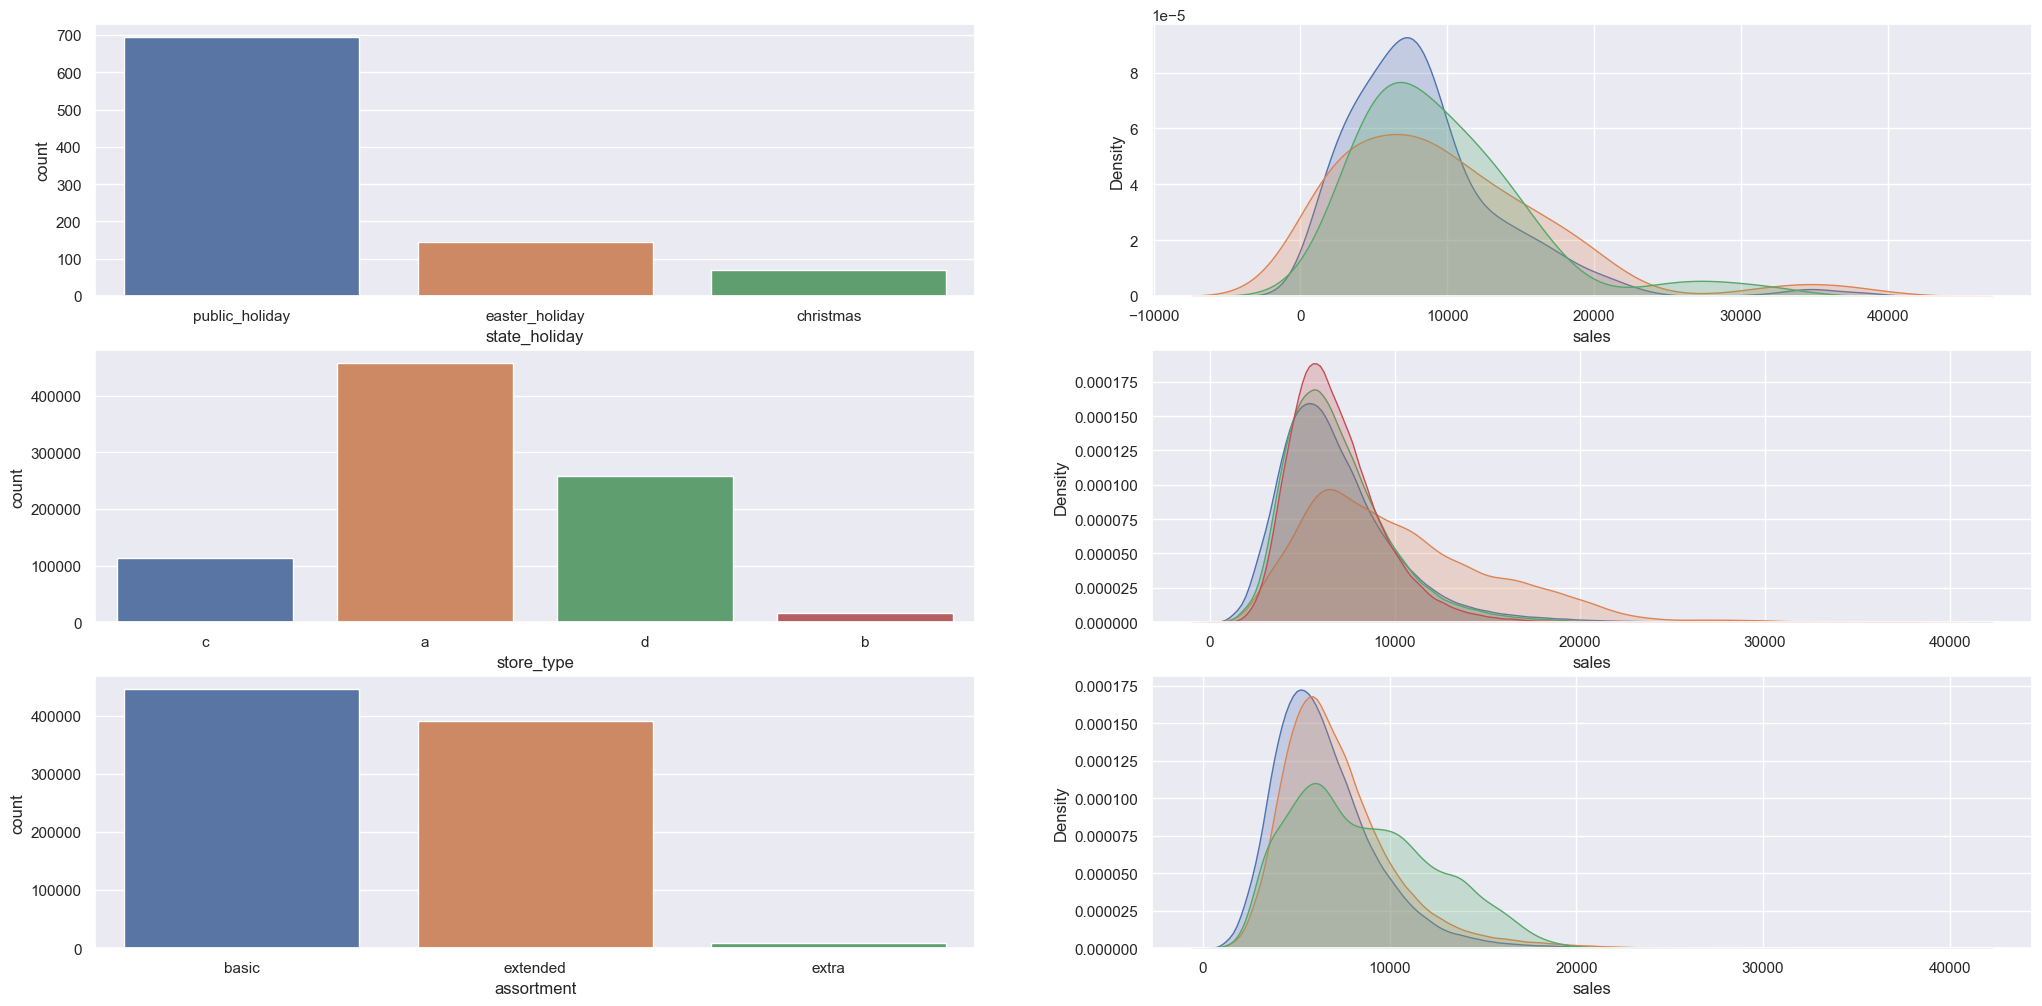

In [46]:
# state_holiday
plt.subplot (3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot (x=a['state_holiday'])

plt.subplot (3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', fill=True, legend = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', fill=True, legend = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', fill=True, legend = True)

# store_type
plt.subplot (3, 2, 3)
sns.countplot (x=df4['store_type'])

plt.subplot (3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', fill=True, legend = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', fill=True, legend = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', fill=True, legend = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', fill=True, legend = True)

# assortment
plt.subplot (3,2,5)
sns.countplot (x=df4['assortment'])

plt.subplot (3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', fill=True, legend = True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', fill=True, legend = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', fill=True, legend = True)


In [47]:
# <notion>
#     plt.subplot ( rows, cols , position) - para plotar um grid onde serao inseridos os graficos

#     # state_holiday
#     plt.subplot (3, 2, 1)
#     a = df4[df4['state_holiday'] != 'regular_day']
#     sns.countplot (x=a['state_holiday'])

#     plt.subplot (3, 2, 2)
#     sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', fill=True, legend = True)
#     sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', fill=True, legend = True)
#     sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', fill=True, legend = True)

IndentationError: unexpected indent (634891731.py, line 2)

## Analise Bivariada]
Dois objetivos em cada analise

    1. Validar/refutar a hipotese
    2. Entender relevancia da variavel para o modelo 

### H1. Lojas com maior sortimentos deveriam vender mais.
**FALSE**. Lojas com MAIOR sortimento vendem MENOS.


In [48]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

In [49]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

<AxesSubplot:xlabel='assortment', ylabel='sales'>

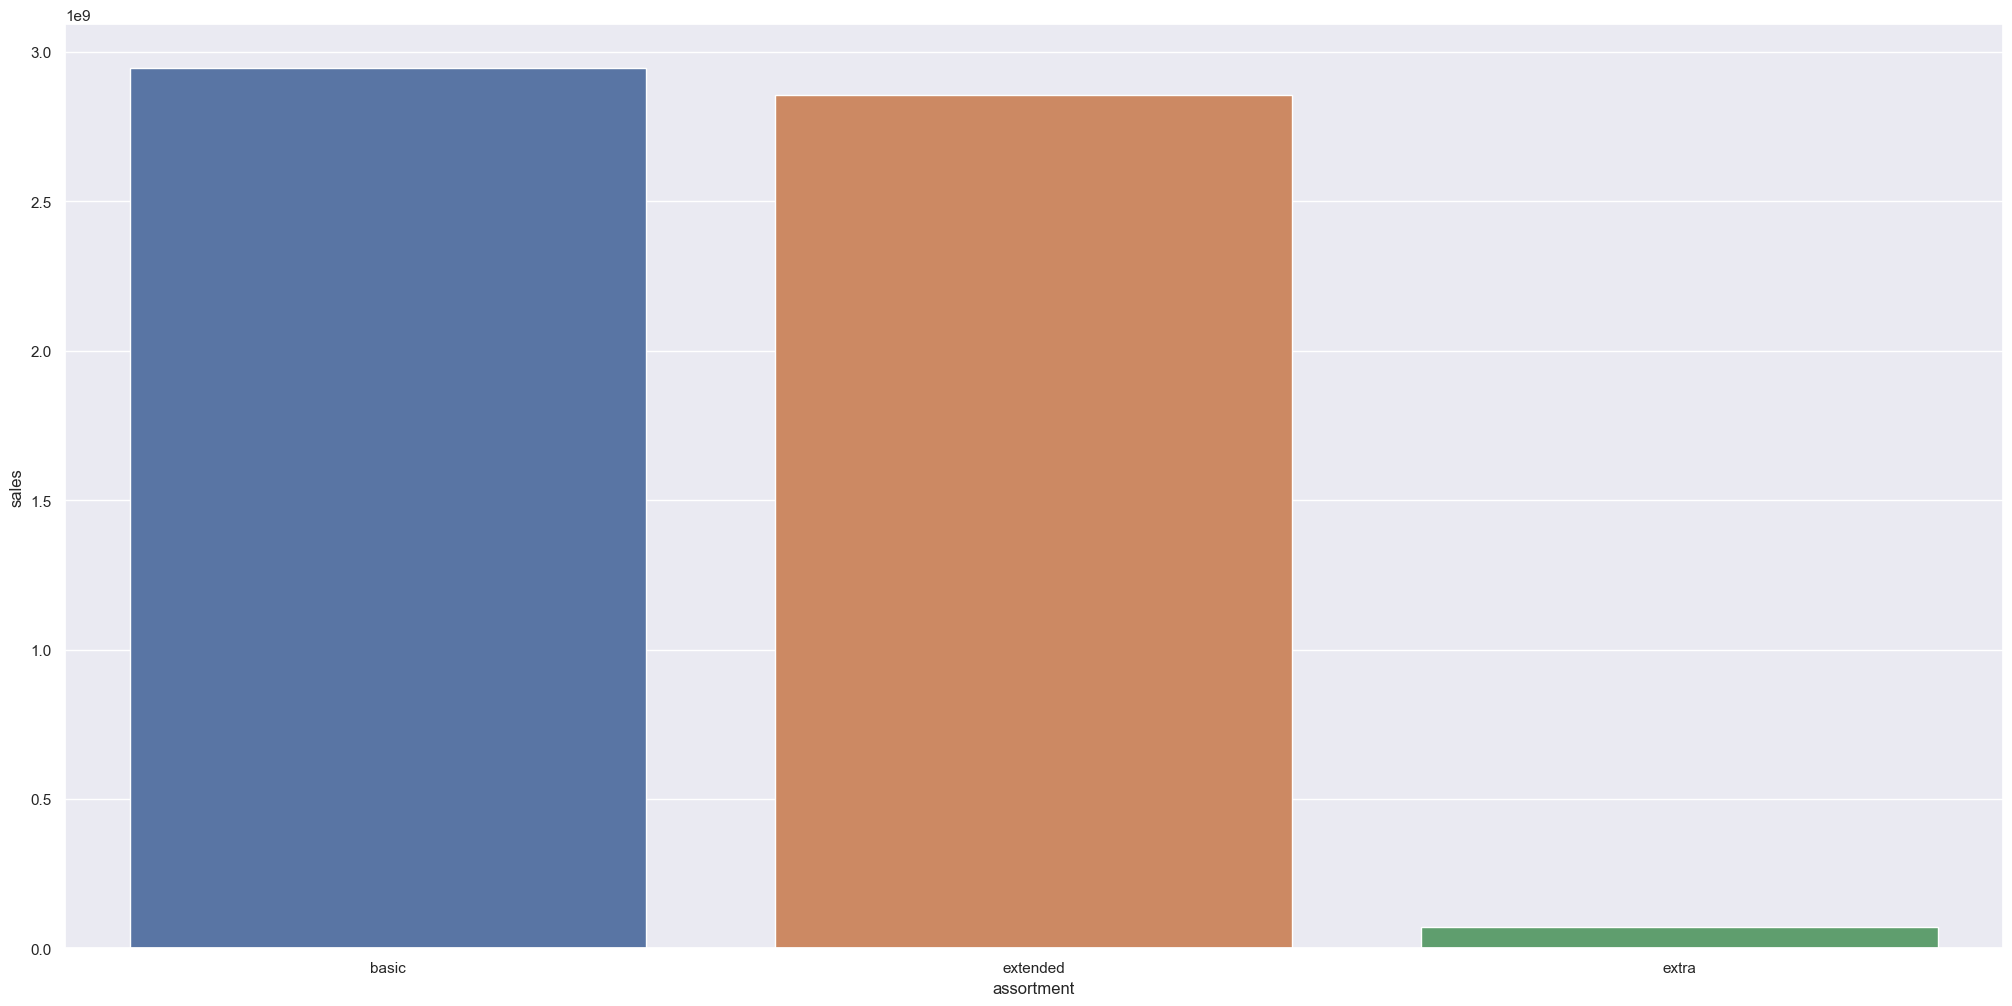

In [50]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot (x = 'assortment', y = 'sales', data = aux1)


<AxesSubplot:xlabel='year_week'>

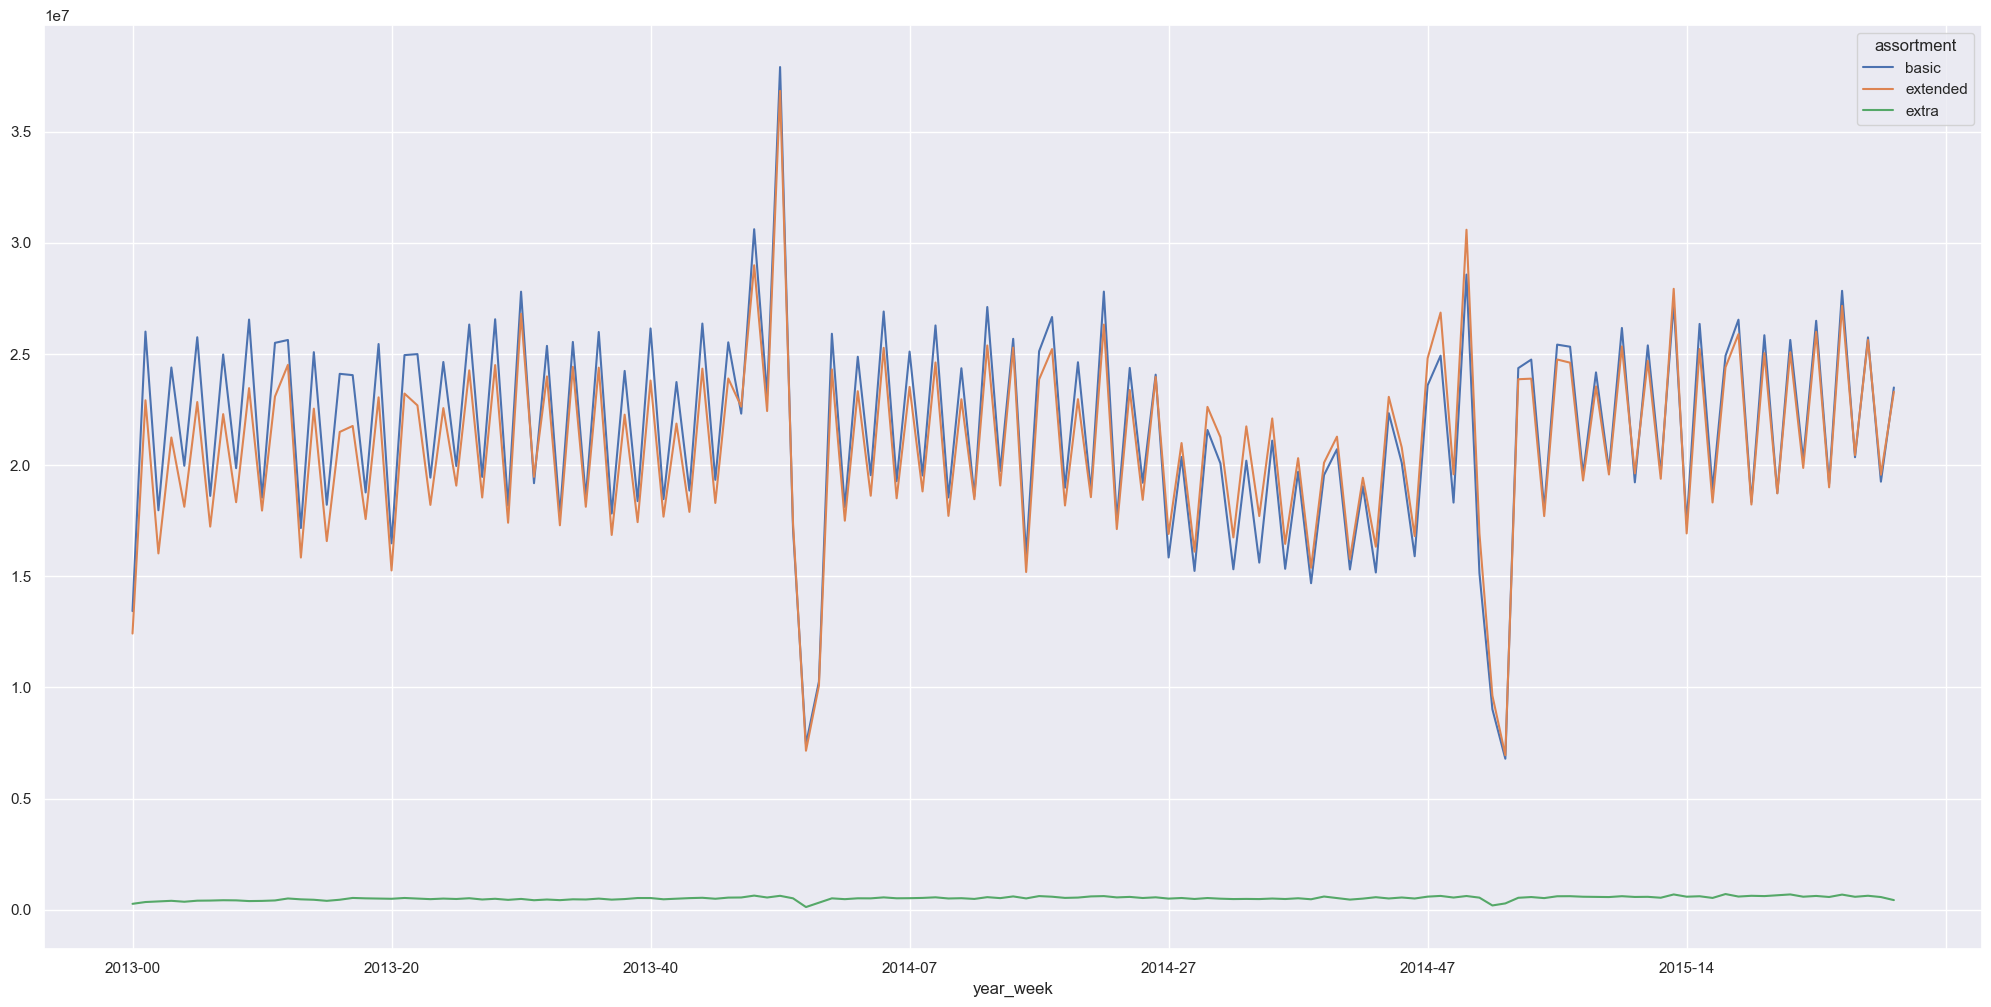

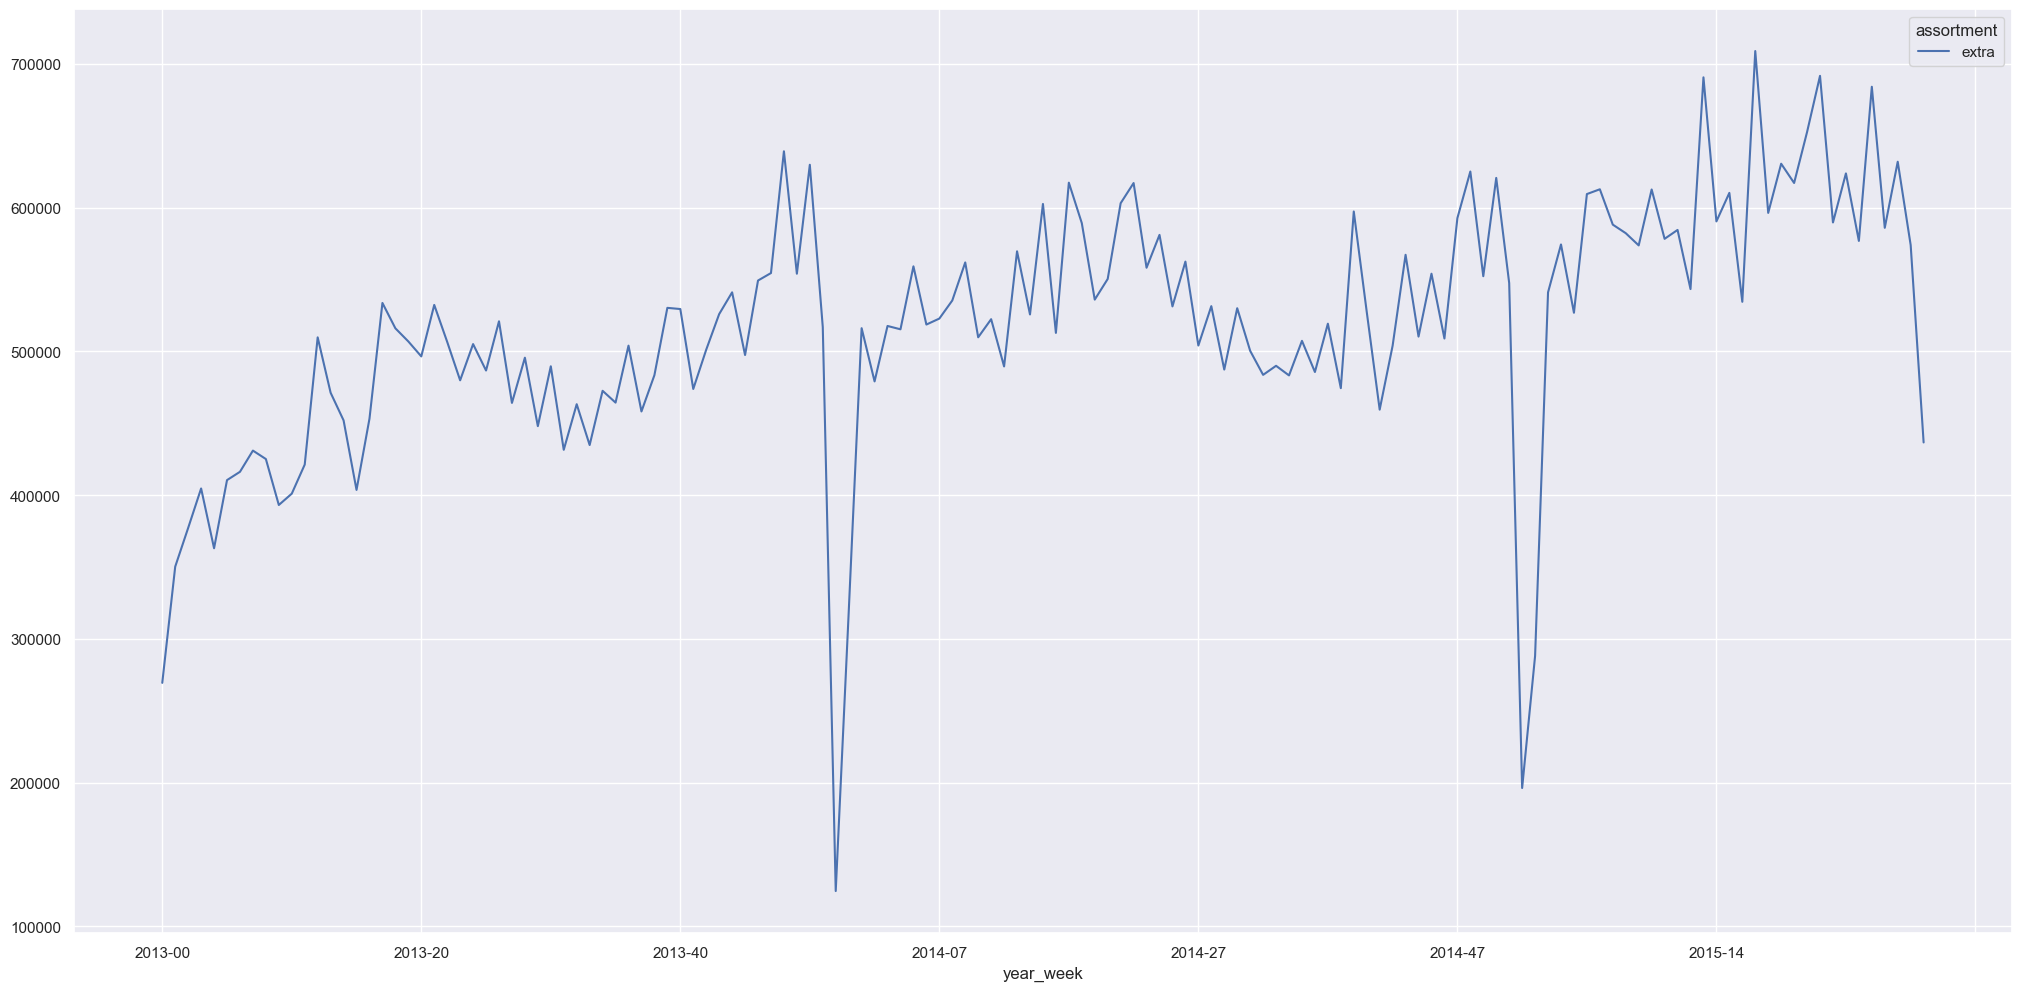

In [51]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot (index = 'year_week' , columns = 'assortment', values= 'sales').plot()

aux3 =  aux2[aux2['assortment'] == 'extra']
aux3.pivot (index='year_week' , columns= 'assortment', values = 'sales').plot()

In [52]:
# <notion>

# .pivot (index = 'year_week' , columns = 'assortment', values= 'sales').plot() - para editar os indices e colunas do dataset e plotar em linha
    # aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
    # aux2.pivot (index = 'year_week' , columns = 'assortment', values= 'sales').plot()                                                                     

### H2. Lojas com competidores mais próximos deveriam vender menos.
**REVISAR ESSA HIPOTESE**


<AxesSubplot:>

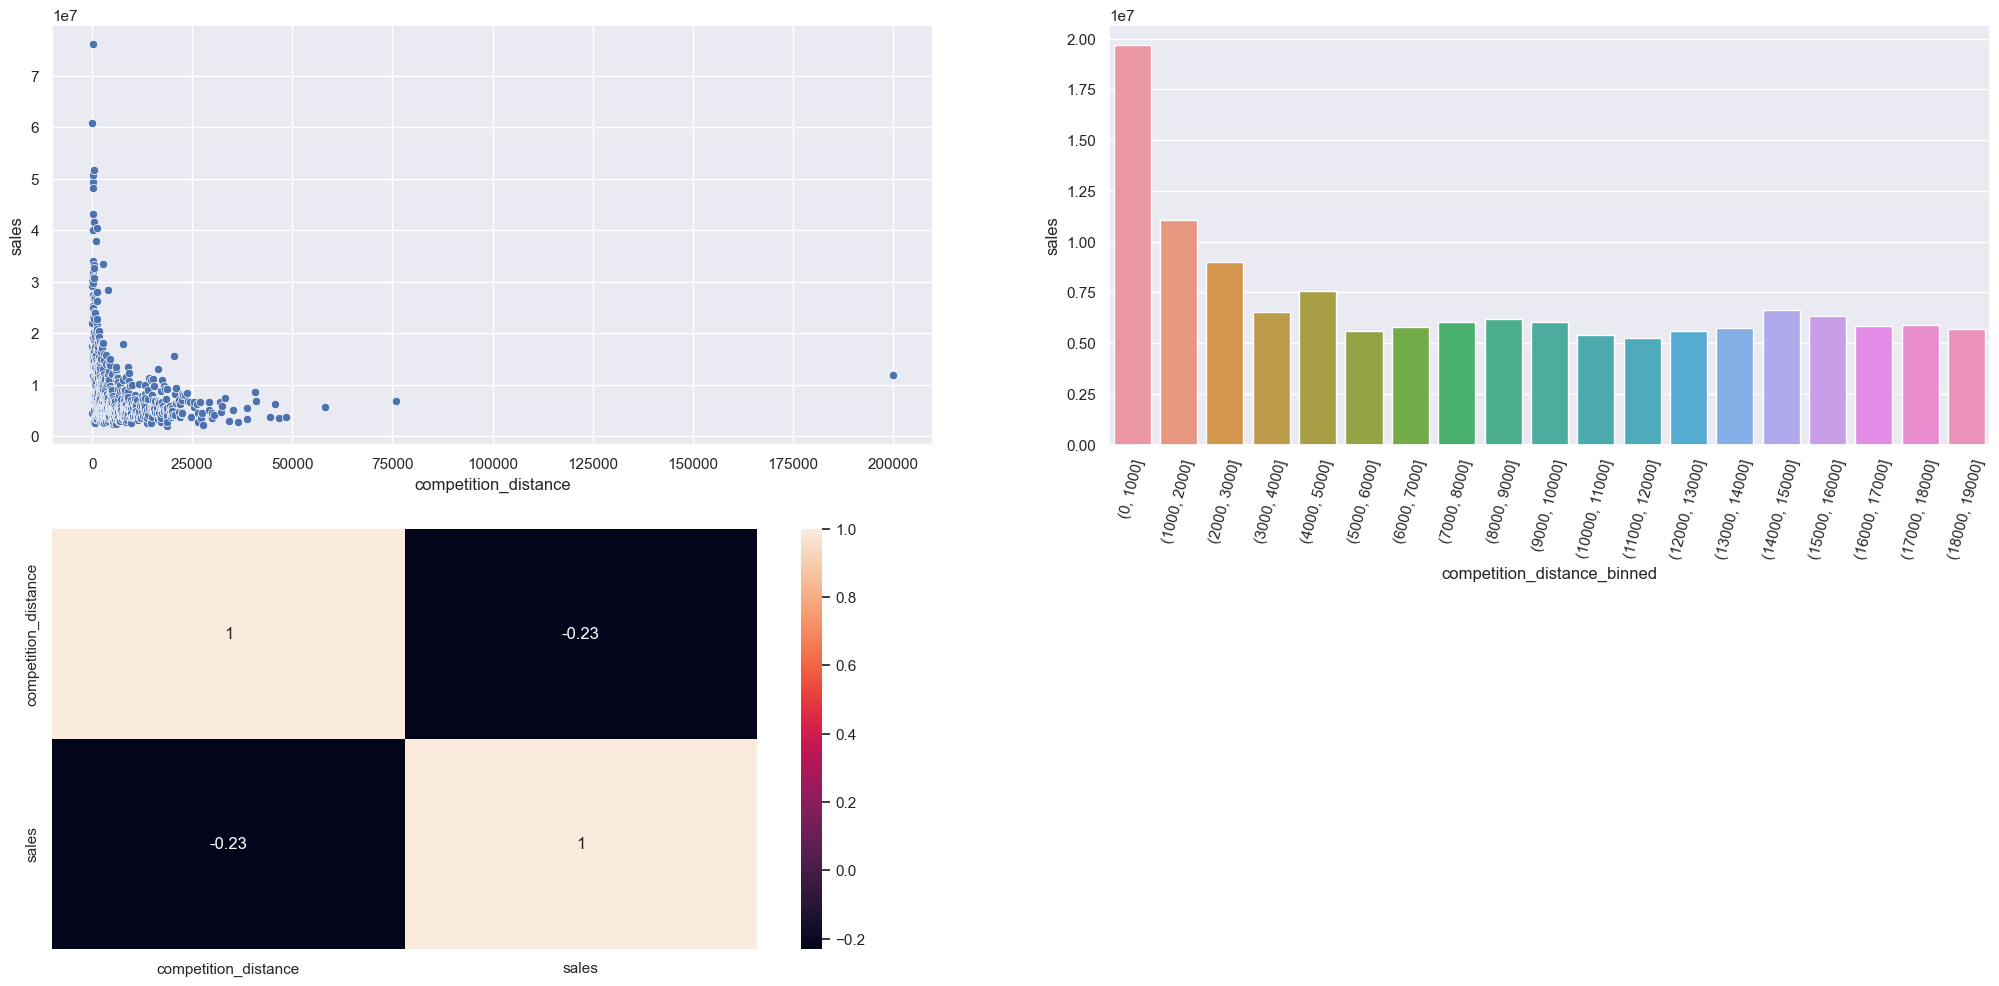

In [53]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot (2, 2, 1)
sns.scatterplot (x='competition_distance' ,y='sales' , data= aux1)
# se ha mais lojas com distancia menor entre concorrentes, havera tambem mais vendas (somatorio). O certo seria usar a
    # media para avaliar melhor o fenomeno

plt.subplot (2, 2, 2)
bins = list ( np.arange(0, 20000, 1000) ) 
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins = bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby ('competition_distance_binned').mean().reset_index()
sns.barplot (x= 'competition_distance_binned', y= 'sales', data = aux2)
plt.xticks(rotation=75);


plt.subplot (2,2,3)
sns.heatmap (aux1.corr (method = 'pearson'), annot = True)

In [54]:
# <notion>

# np.arange( )- para criar uma lista de bins com o numpy
#     bins = list ( np.arange(0, 20000, 1000) )


# pd.cut( df, bins = ) - para estabelecer intervalos 'maiores' com base no tamanho do bin
#     aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins = bins )

# sns.heatmap (df.corr (method=), annot=bool) - mapa de calor para verificar correlacao 
#     sns.heatmap (aux1.corr (method = 'pearson'), annot = True)

### H3. Lojas com competidores à mais tempo deveriam vendem mais.
FALSA. Lojas com competidores a mais tempo vendem menos

<AxesSubplot:>

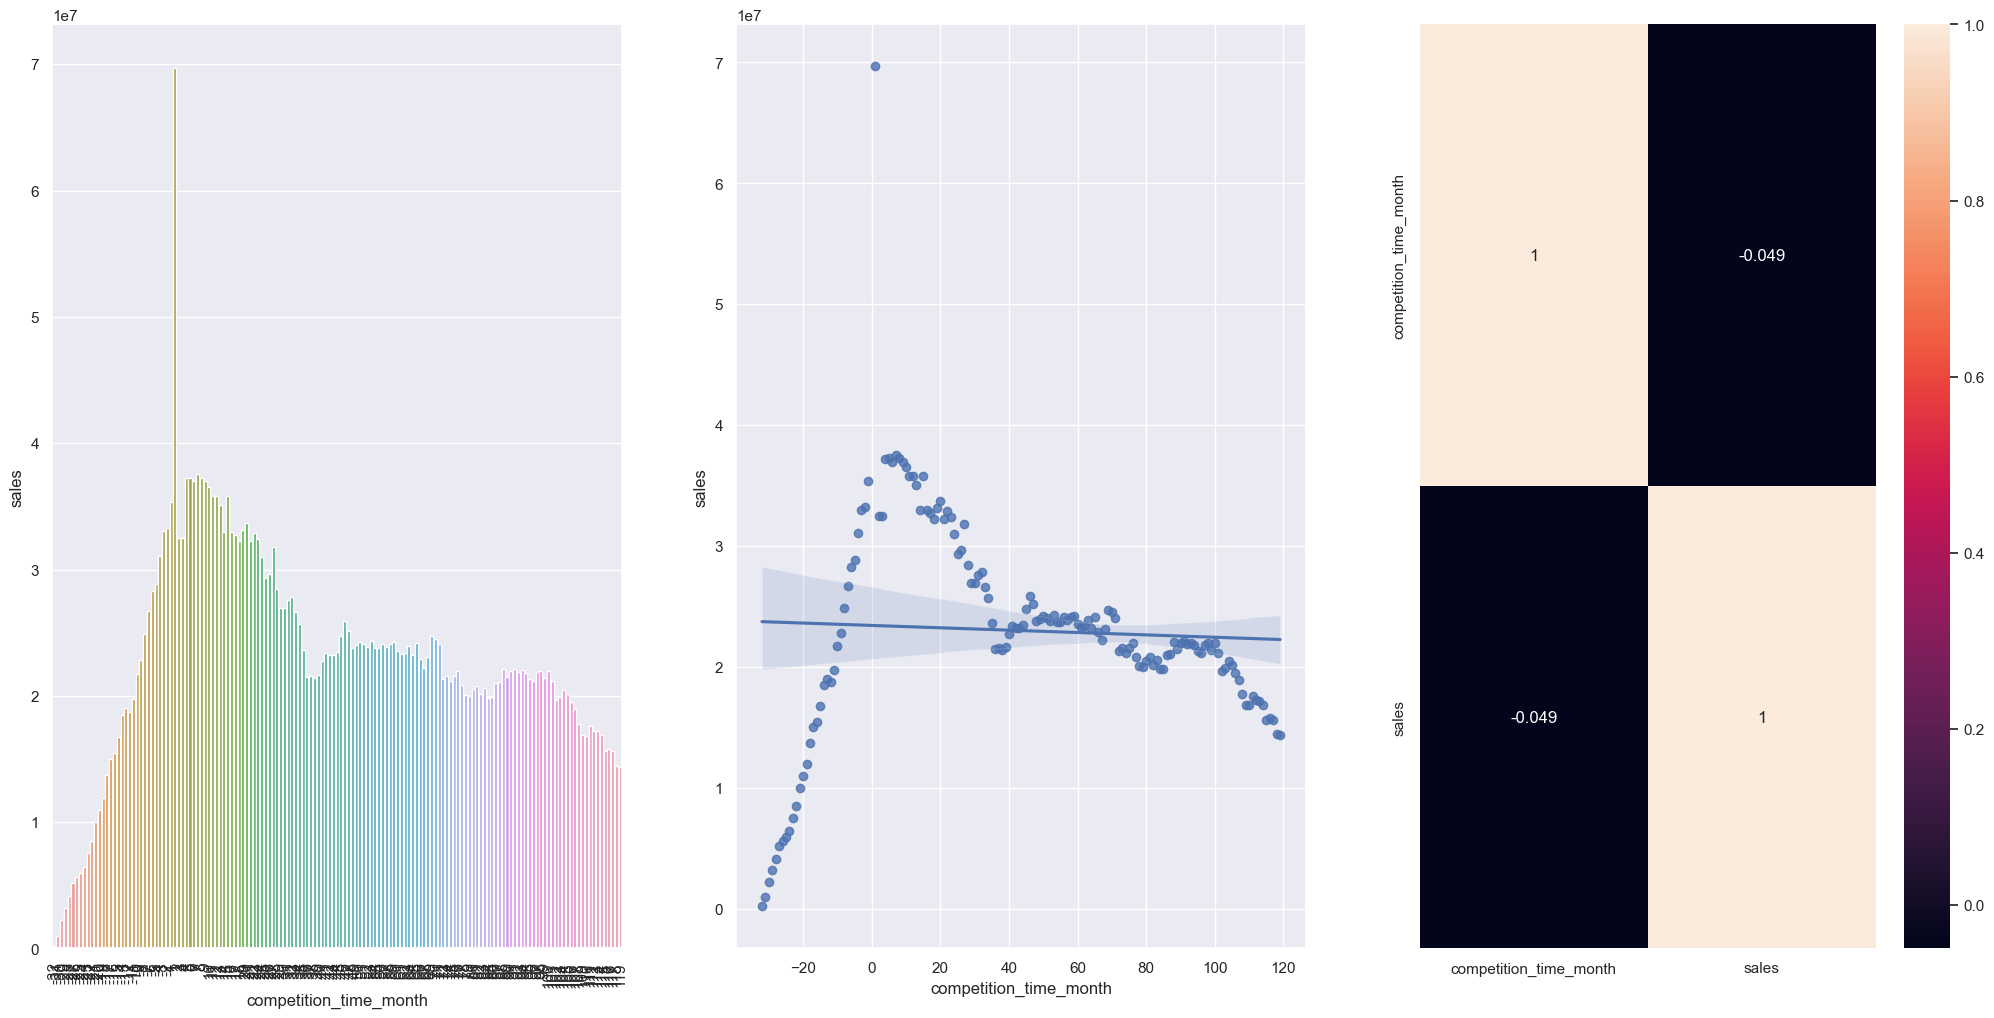

In [55]:
plt.subplot (1, 3, 1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month']<120) & (aux1['competition_time_month'] != 0)]
sns.barplot (x='competition_time_month', y='sales', data = aux2);
plt.xticks (rotation = 90);
plt.subplot (1, 3, 2)
sns.regplot (x = 'competition_time_month', y='sales', data=aux2)

plt.subplot (1, 3, 3)
sns.heatmap (aux2.corr (method = 'pearson'), annot = True)

In [56]:
# <notion>

# sns.regplot - grafico para representar a tendencia dos dados e entender relevancia para os modelos
#         sns.regplot (x = 'competition_time_month', y='sales', data=aux2)


### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
FALSA. Lojas com promocoes ativas por mais tempo vendem menos depois de um certo periodo de promocao 

<AxesSubplot:>

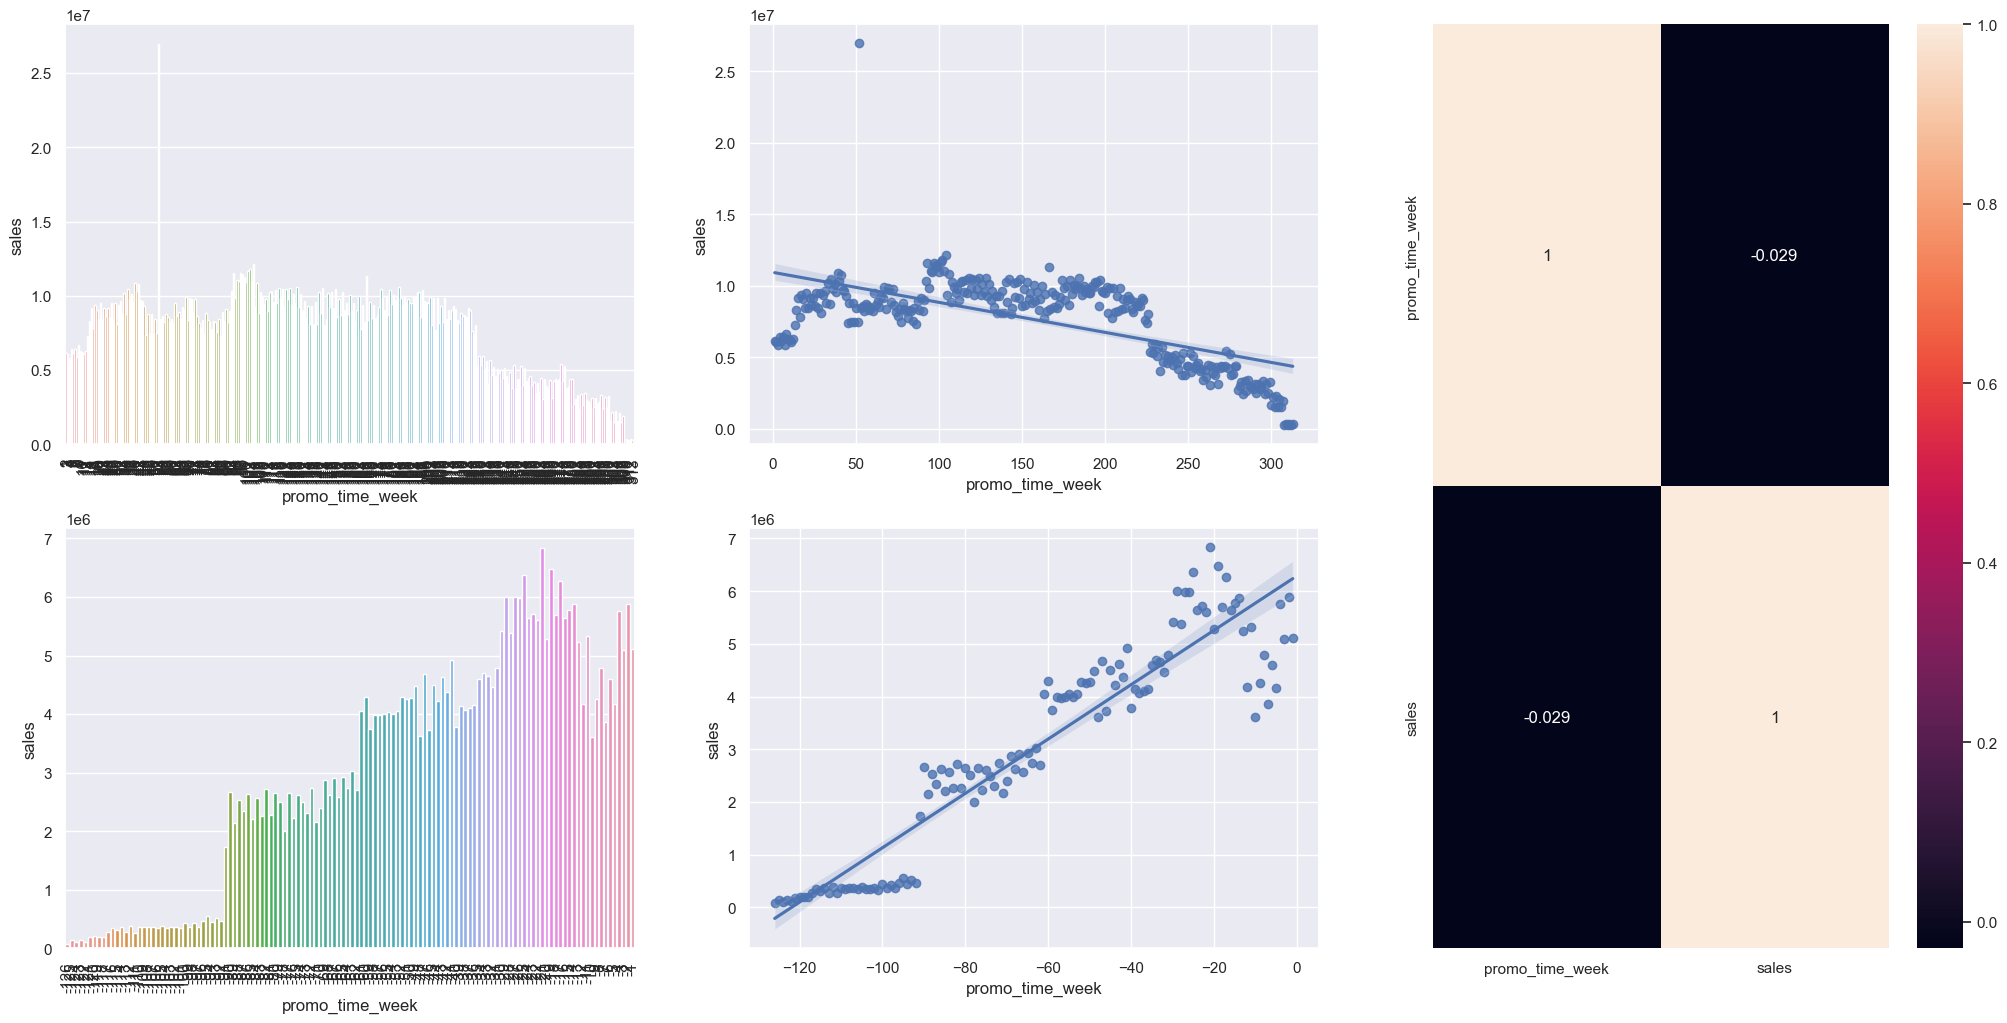

In [57]:
aux1 = df4[['promo_time_week','sales']].groupby ('promo_time_week').sum().reset_index ()

grid = GridSpec (2,3)

# promo extendido. 
    # derivada de 'date' - 'promo_since' (rever Feature Engineering). Se >0 é apos abertura da promo extendida
plt.subplot ( grid[0,0] )
aux2 = aux1[aux1['promo_time_week']>0]
sns.barplot (x= 'promo_time_week', y='sales' , data= aux2)
plt.xticks ( rotation = 90 );

plt.subplot ( grid[0,1] )
sns.regplot (x='promo_time_week' ,y='sales' ,data= aux2)

#promo regular.     
plt.subplot ( grid[1,0] ) 
aux3 = aux1[aux1['promo_time_week']<0]
sns.barplot (x= 'promo_time_week', y='sales' , data= aux3)
plt.xticks ( rotation = 90 );

plt.subplot (grid[1,1])
sns.regplot (x='promo_time_week' ,y='sales' ,data=aux3 )

#heatmap
plt.subplot (grid[:,2])
sns.heatmap (aux1.corr (method = 'pearson'), annot=True)

A correlação encontrada foi de aproximadamente |0.02|, um valor muito baixo, provavelmente devido ao periodo em que houve uma quebra da tendencia no 'promo_time_week'>0. Com isso, ha indicio de que essa feature nao sera relevante ao modelo 

### <s> H5. Lojas com mais dias de promoção deveriam vender mais. </s>


### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promocoes consecutivas vendem menos


In [58]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


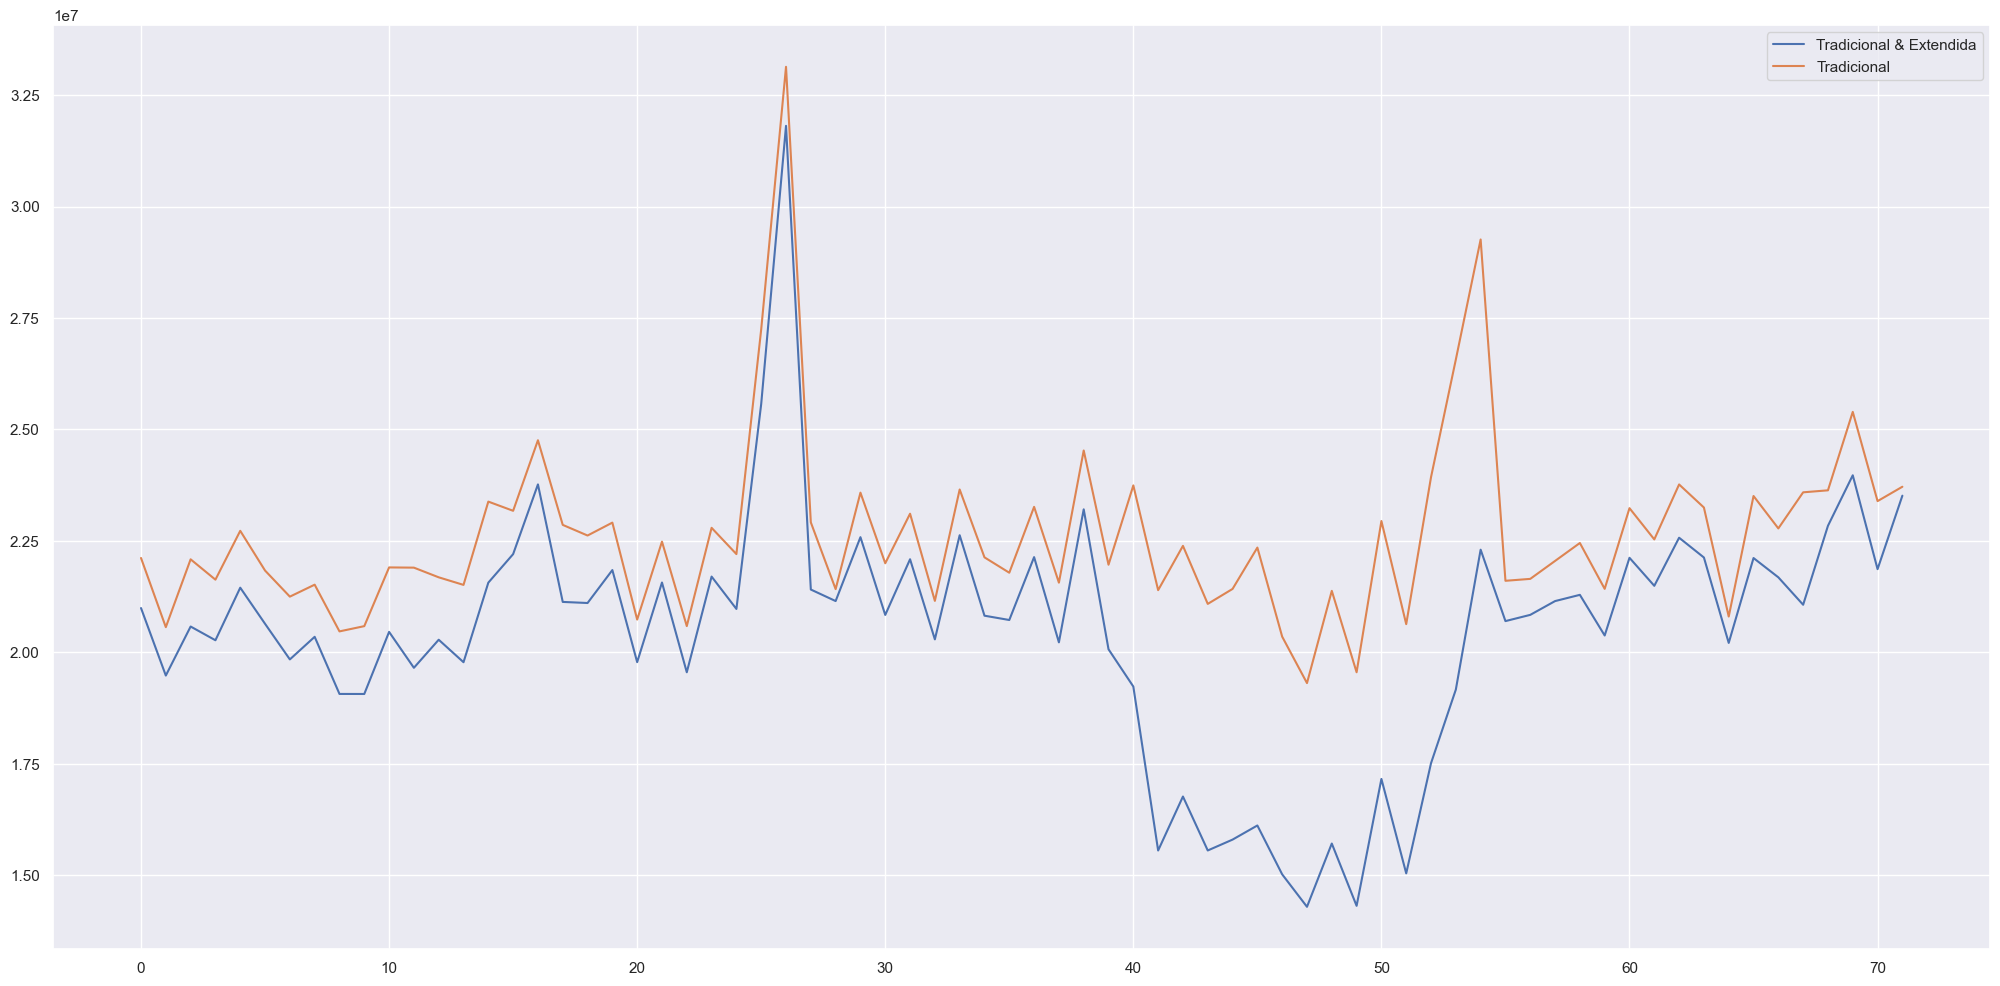

In [59]:
aux1 = df4[(df4['promo']==1)&(df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo']==1)&(df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)
ax.legend (labels =['Tradicional & Extendida','Tradicional']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado do Natal vendem menos


<AxesSubplot:xlabel='year', ylabel='sales'>

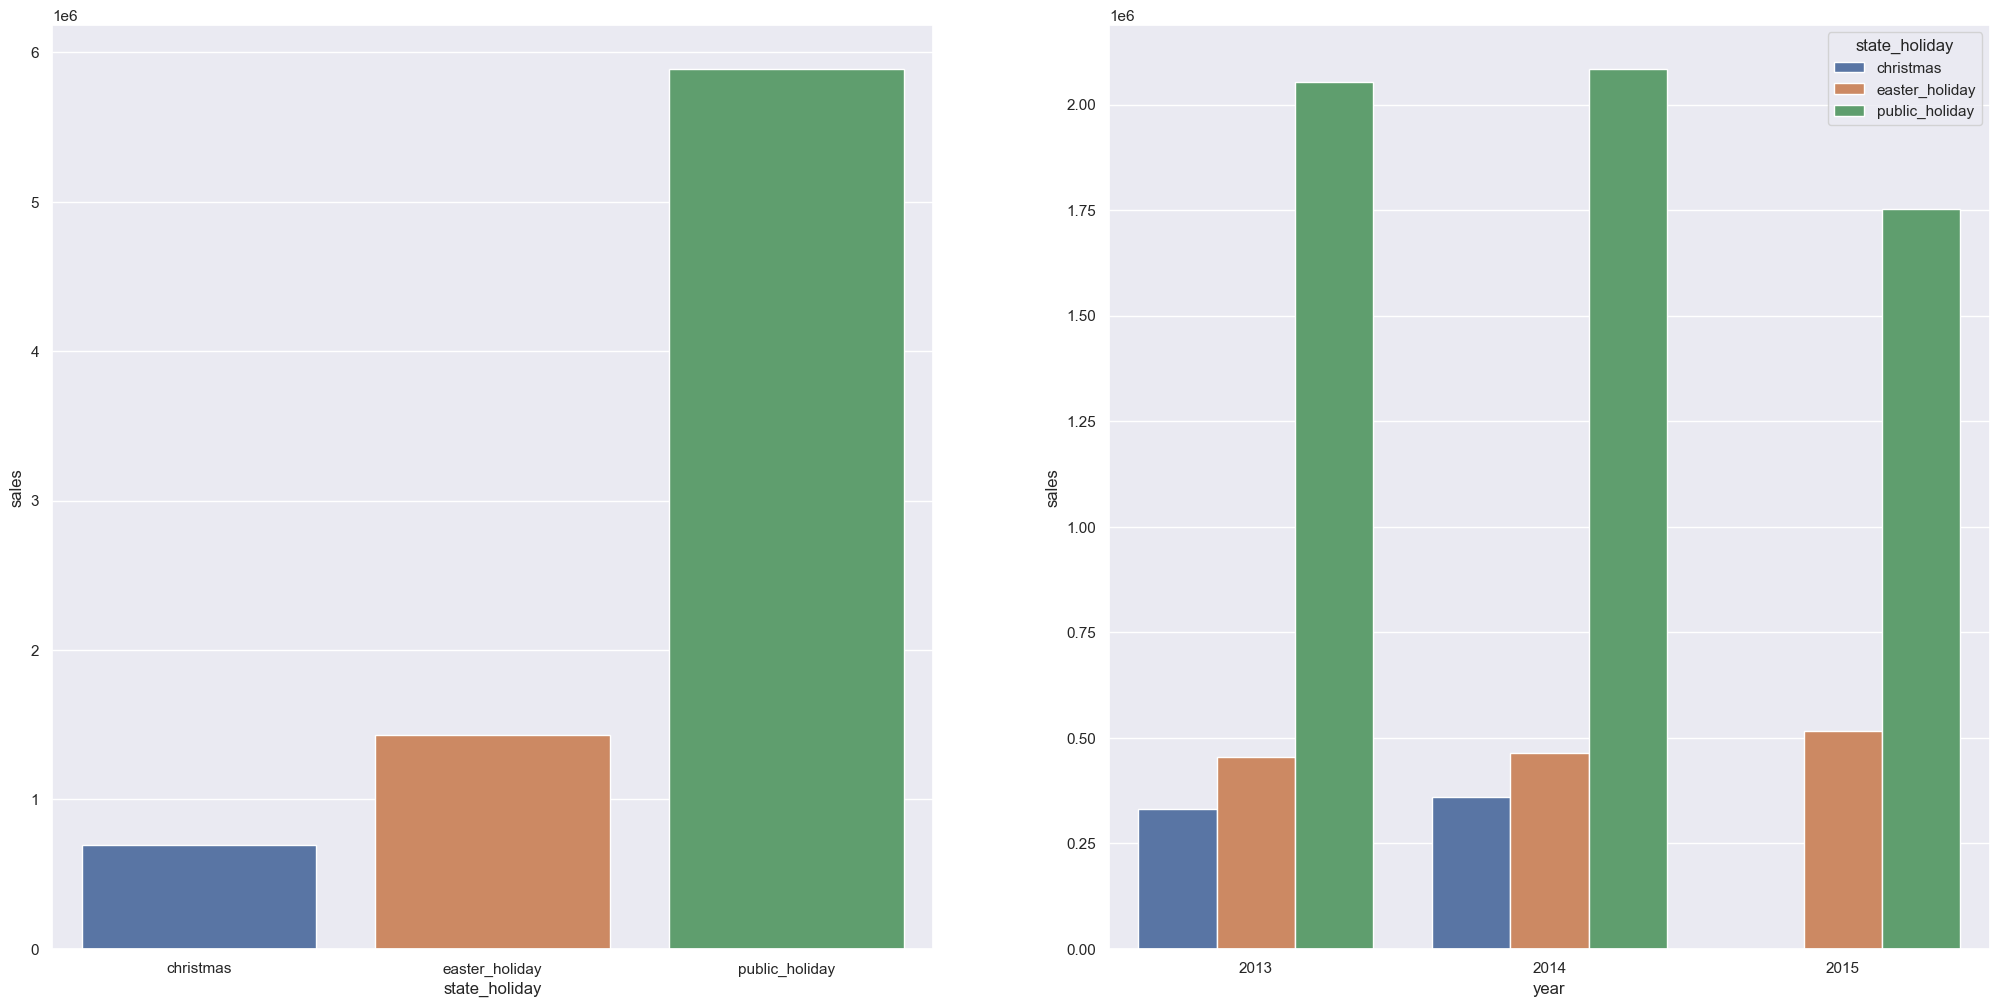

In [60]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot (1, 2, 1)
aux1 = aux[['state_holiday','sales']].groupby ('state_holiday').sum().reset_index()
sns.barplot (x='state_holiday' ,y= 'sales', data= aux1)

plt.subplot (1, 2, 2)
aux2 = aux[['year','state_holiday','sales']].groupby (['year','state_holiday']).sum().reset_index()
sns.barplot (x='year' ,y= 'sales', hue ='state_holiday', data= aux2)


### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos


<AxesSubplot:>

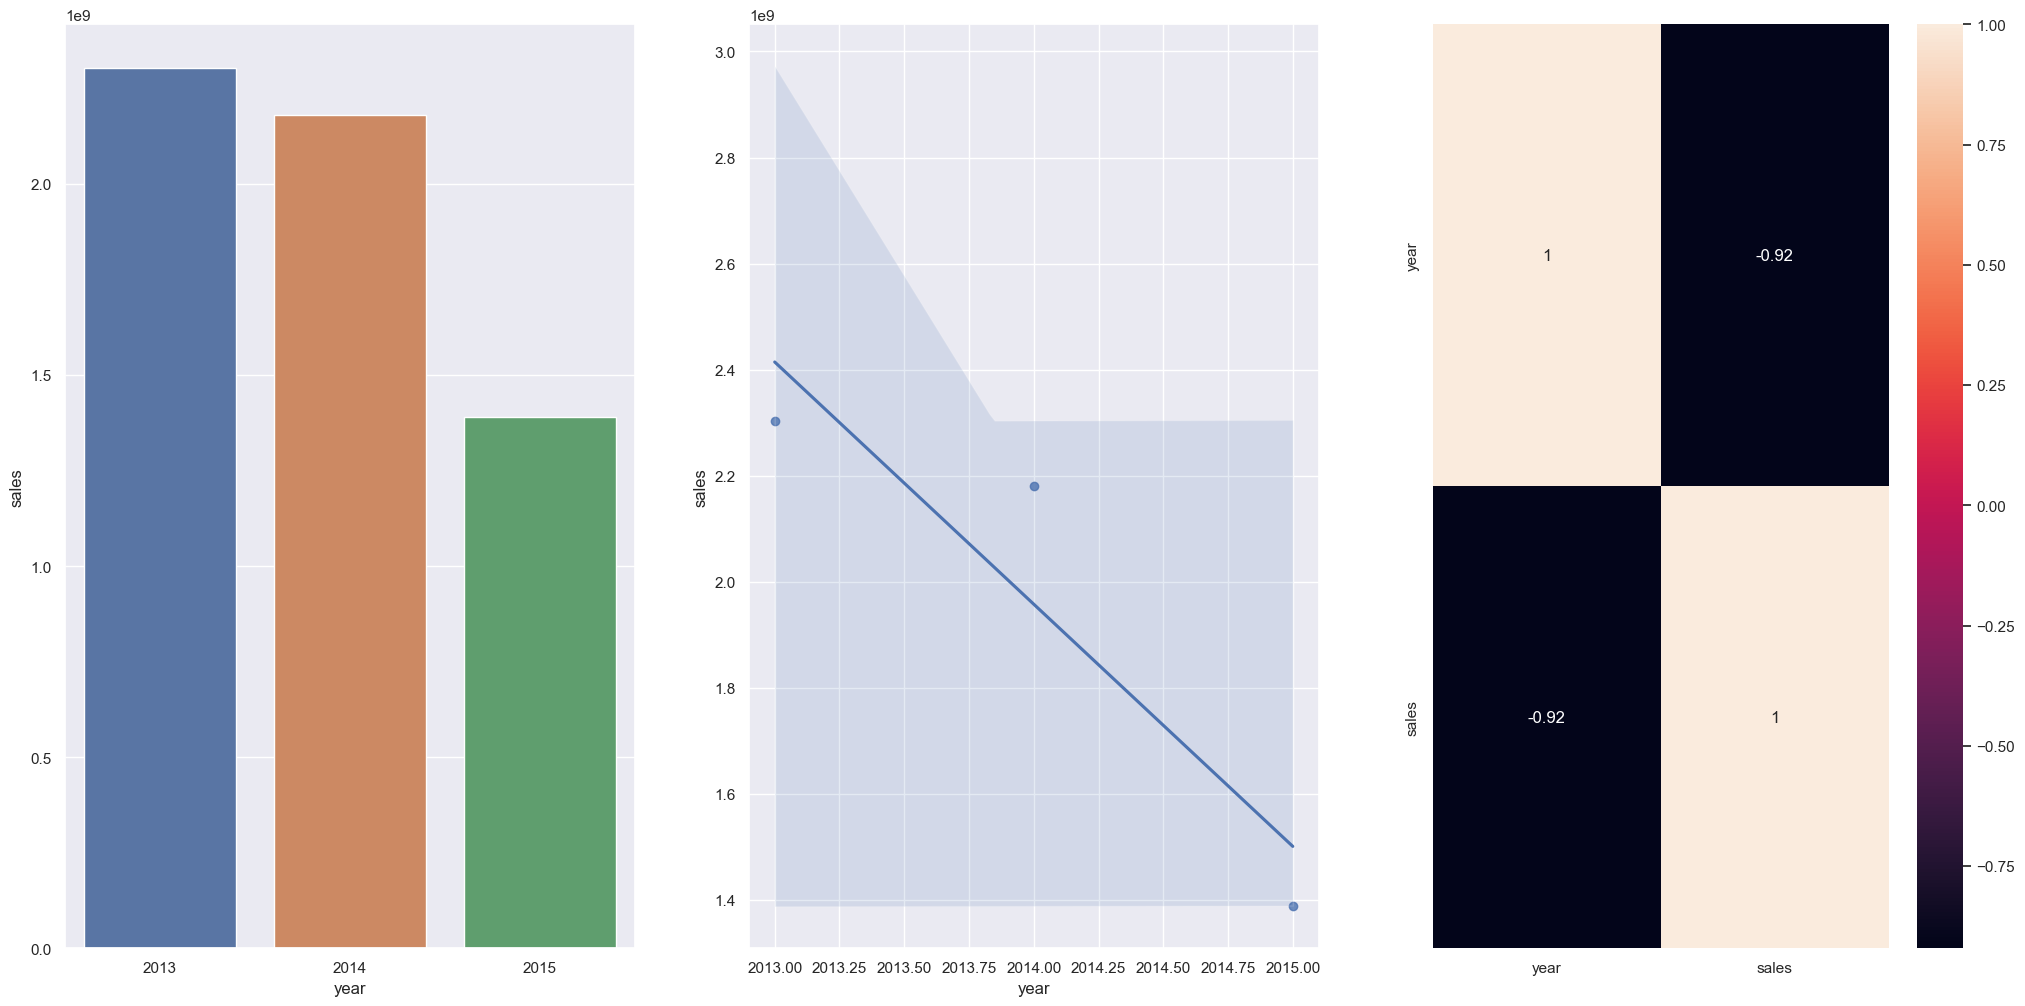

In [61]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot (1,3,1)
sns.barplot(x='year',y='sales', data=aux1)

plt.subplot (1,3,2)
sns.regplot(x='year',y='sales', data=aux1)

plt.subplot (1, 3, 3)
sns.heatmap(aux1.corr (method='pearson'), annot = True)

O ano de 2015 nao esta completo, portanto ele enviesa a tendencia de queda

### H9. Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano

<AxesSubplot:>

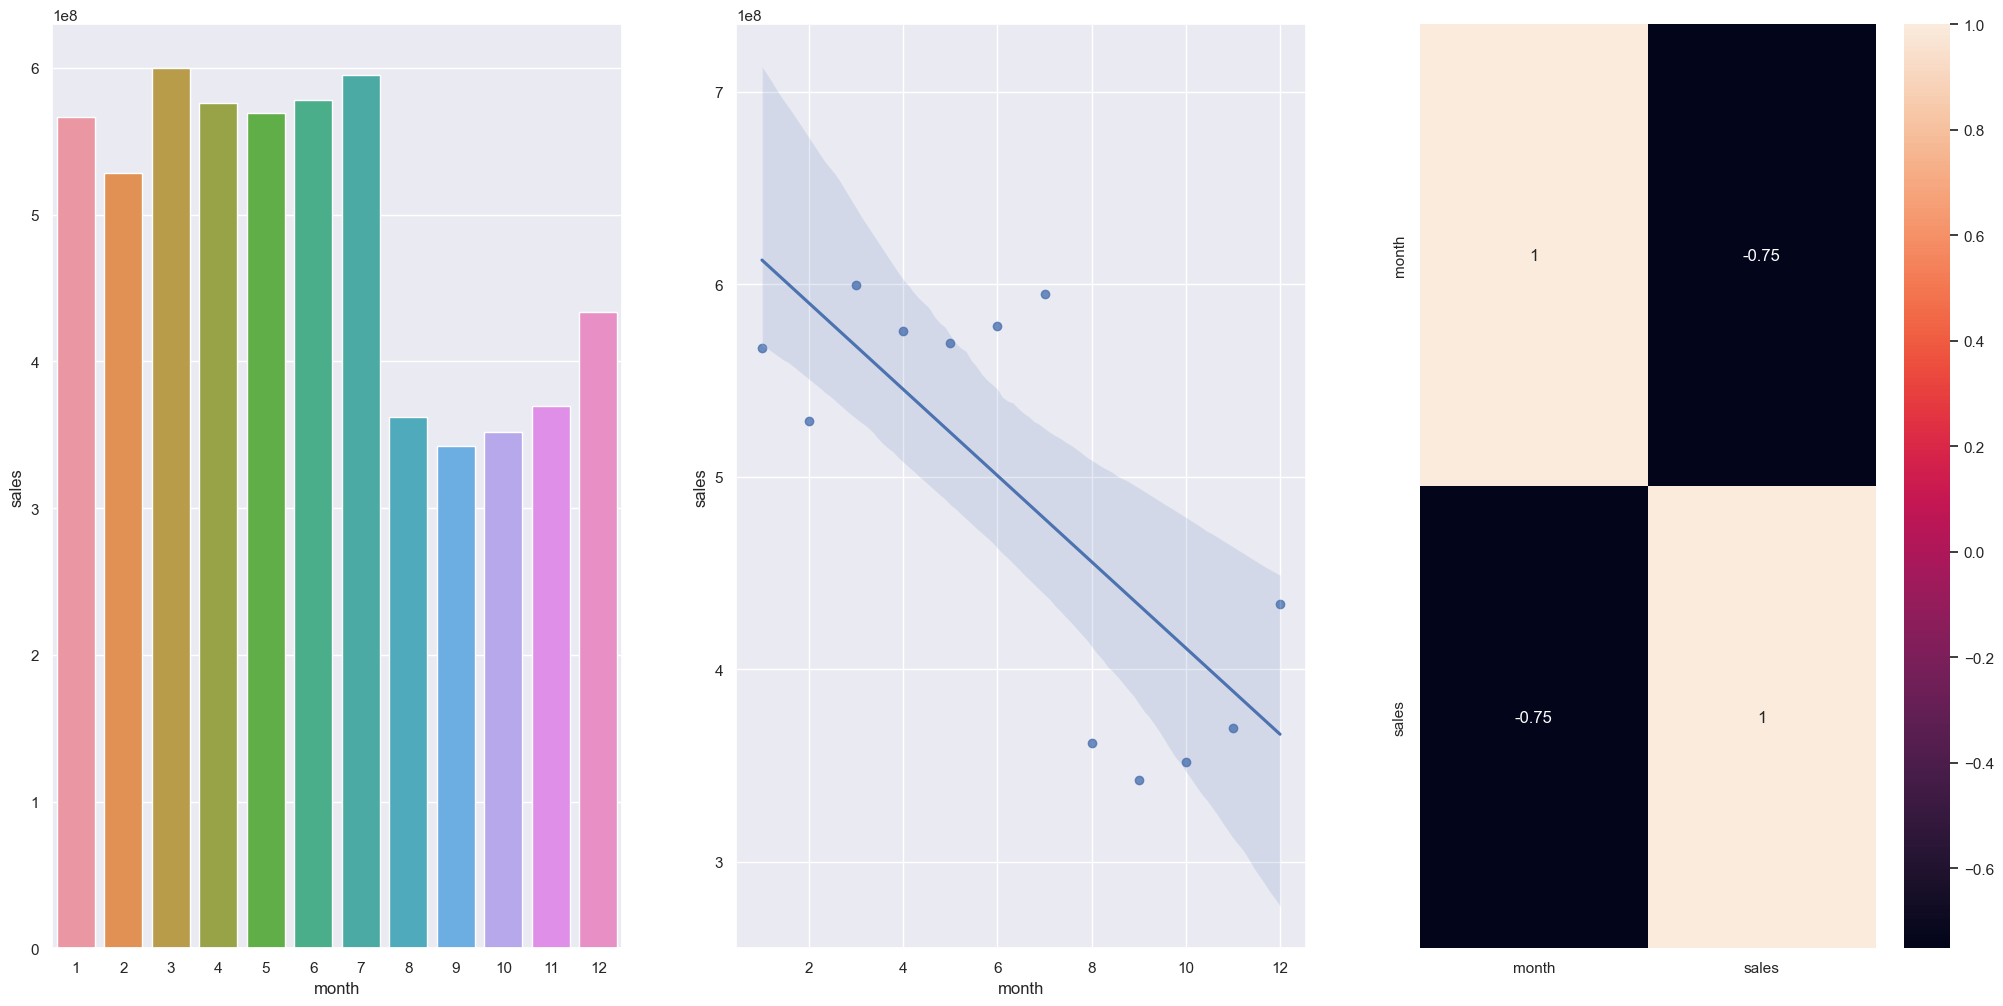

In [62]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot (1,3,1)
sns.barplot(x='month',y='sales', data=aux1)

plt.subplot (1,3,2)
sns.regplot(x='month',y='sales', data=aux1)

plt.subplot (1, 3, 3)
sns.heatmap(aux1.corr (method='pearson'), annot = True)

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** As lojas vendem mais depois do dia 10 de cada mes

<AxesSubplot:xlabel='before_after_10', ylabel='sales'>

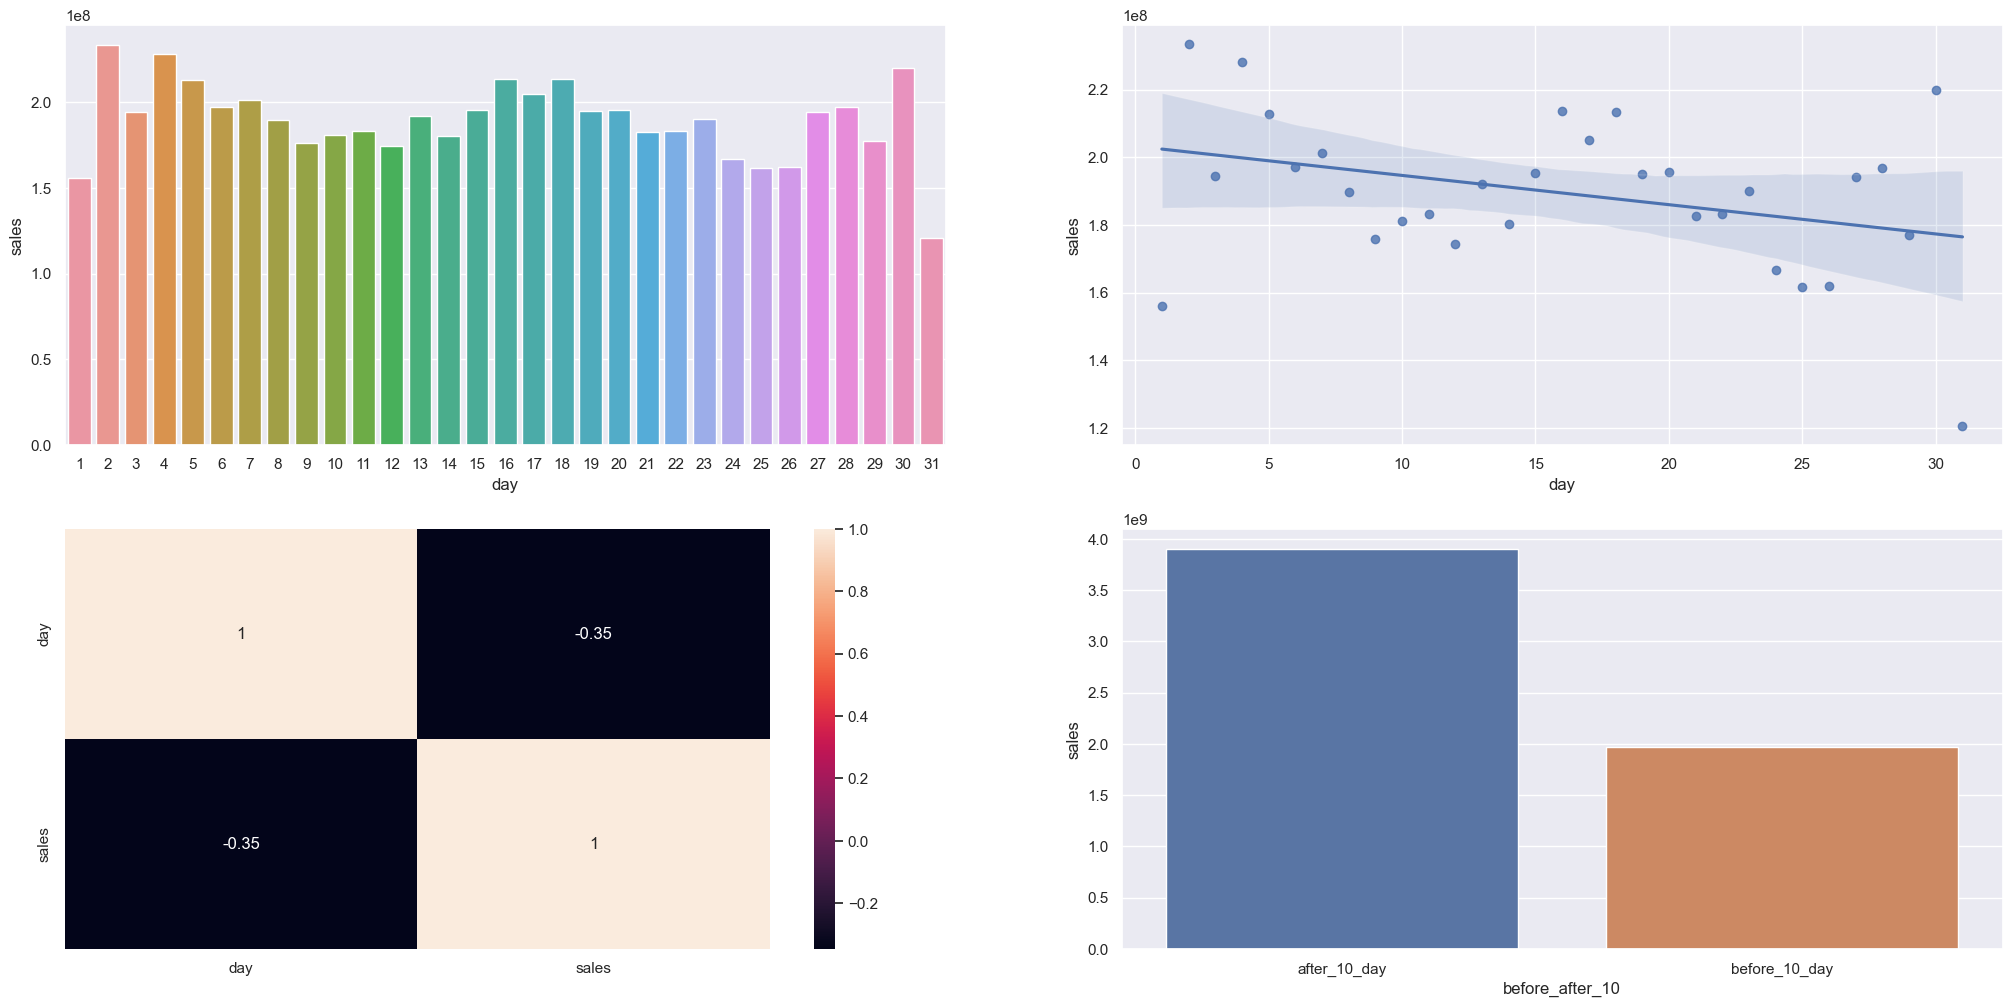

In [63]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot (2,2,1)
sns.barplot(x='day',y='sales', data=aux1)

plt.subplot (2,2,2)
sns.regplot(x='day',y='sales', data=aux1)

plt.subplot (2, 2, 3)
sns.heatmap(aux1.corr (method='pearson'), annot = True)

aux1 ['before_after_10'] = aux1['day'].apply(lambda x: 'before_10_day' if x <= 10 else 'after_10_day')
aux2 = aux1[['before_after_10','sales']].groupby('before_after_10').sum().reset_index()

plt.subplot (2,2,4)
sns.barplot (x='before_after_10', y='sales', data= aux2)

### H11. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos aos finais de semana

<AxesSubplot:>

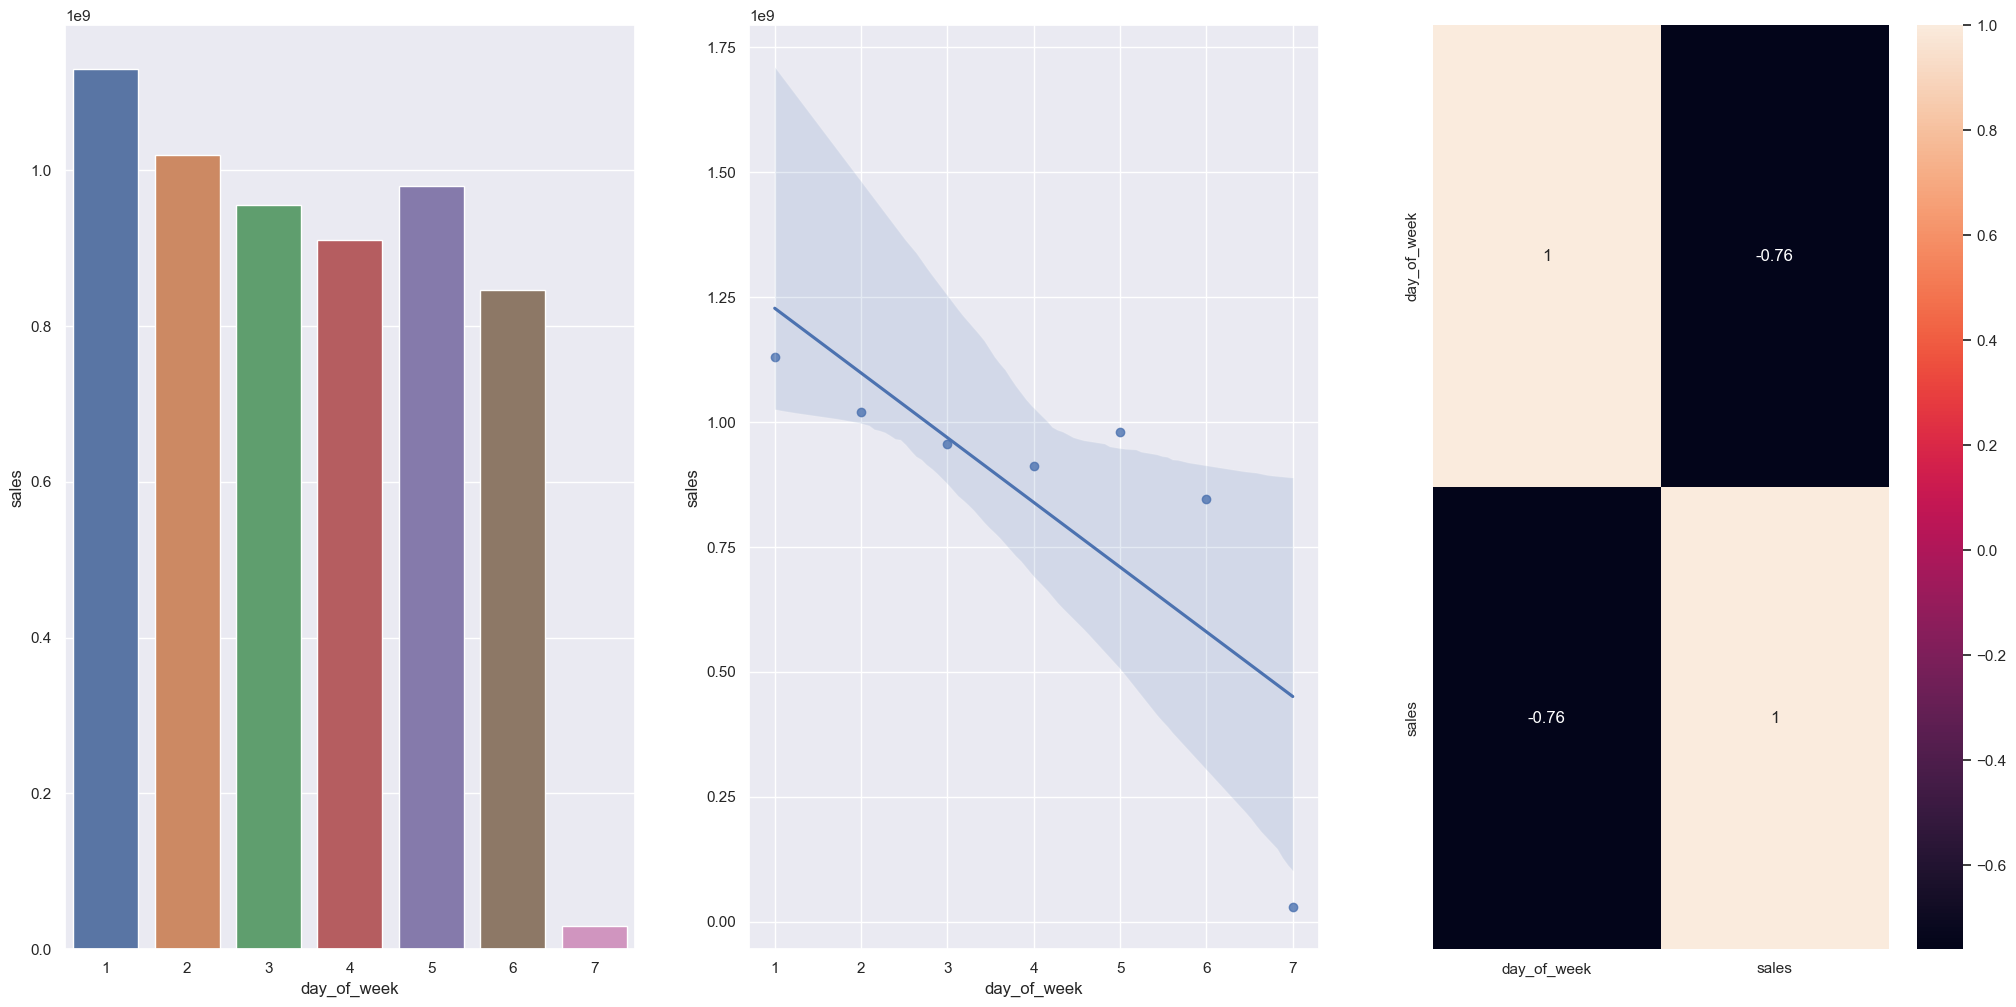

In [64]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot (1,3,1)
sns.barplot(x='day_of_week',y='sales', data=aux1)

plt.subplot (1,3,2)
sns.regplot(x='day_of_week',y='sales', data=aux1)

plt.subplot (1, 3, 3)
sns.heatmap(aux1.corr (method='pearson'), annot = True)

### H12. Lojas deveriam vender menos durante os feriados escolares.
**VERADEIRA** Lojas vendem menos durante os feriados escolares, exceto Julho e Agosto

<AxesSubplot:xlabel='month', ylabel='sales'>

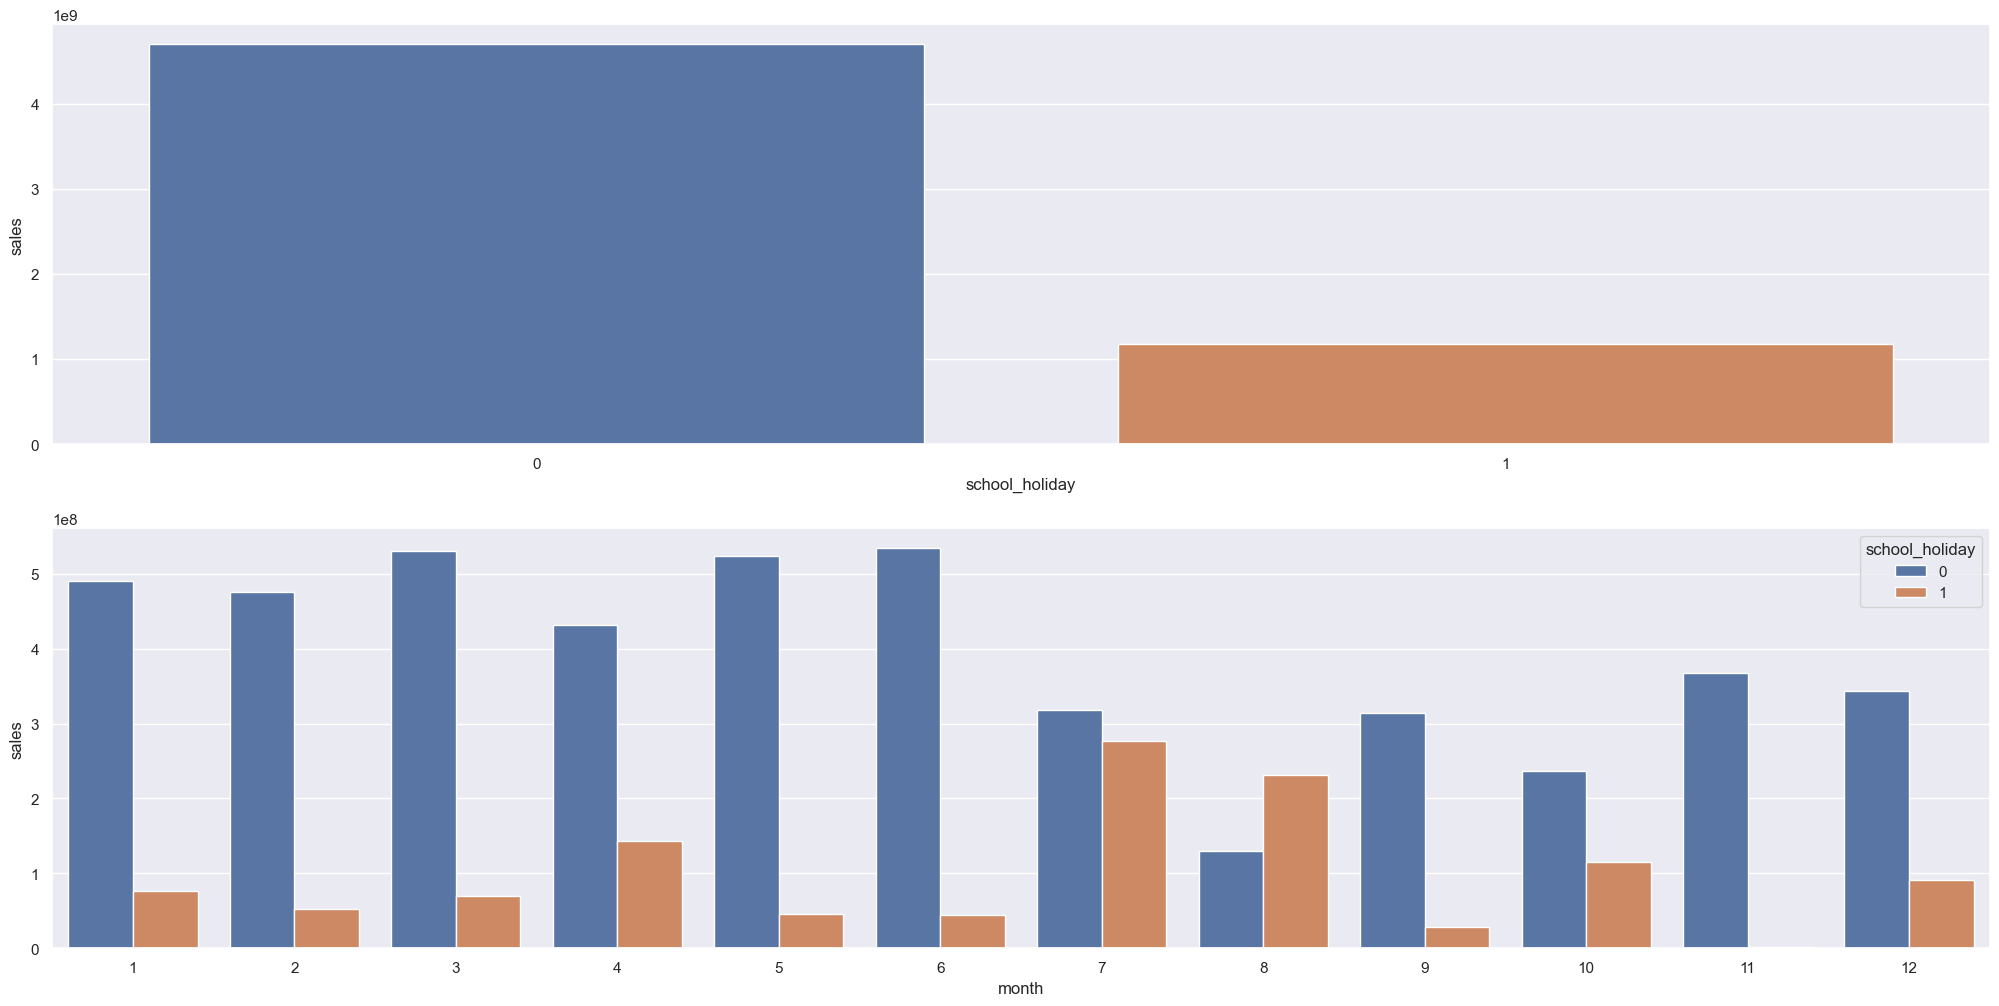

In [65]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot (2,1,1)
sns.barplot (x='school_holiday' , y= 'sales',data=aux1)

aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot (2,1,2)
sns.barplot (x='month', y='sales',hue = 'school_holiday', data= aux2)


### Resumo das hipoteses

In [66]:
from tabulate import tabulate

In [67]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1','FALSA','BAIXA'],
      ['H2','FALSA','MEDIA'],
      ['H3','FALSA','MEDIA'],
      ['H4','FALSA','BAIXA'],
      ['H5','-','-'],
      ['H6','FALSA','BAIXA'],
      ['H7','FALSA','MEDIA'],
      ['H8','FALSA','ALTA'],
      ['H9','FALSA','ALTA'],
      ['H10','VERDADEIRA','ALTA'],
      ['H11','VERDADEIRA','ALTA'],
      ['H11','VERDADEIRA','ALTA']
]

print (tabulate( tab, headers = 'firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           FALSA        BAIXA
H2           FALSA        MEDIA
H3           FALSA        MEDIA
H4           FALSA        BAIXA
H5           -            -
H6           FALSA        BAIXA
H7           FALSA        MEDIA
H8           FALSA        ALTA
H9           FALSA        ALTA
H10          VERDADEIRA   ALTA
H11          VERDADEIRA   ALTA
H11          VERDADEIRA   ALTA


## Analise Multivariada


### Numerical attributes

<AxesSubplot:>

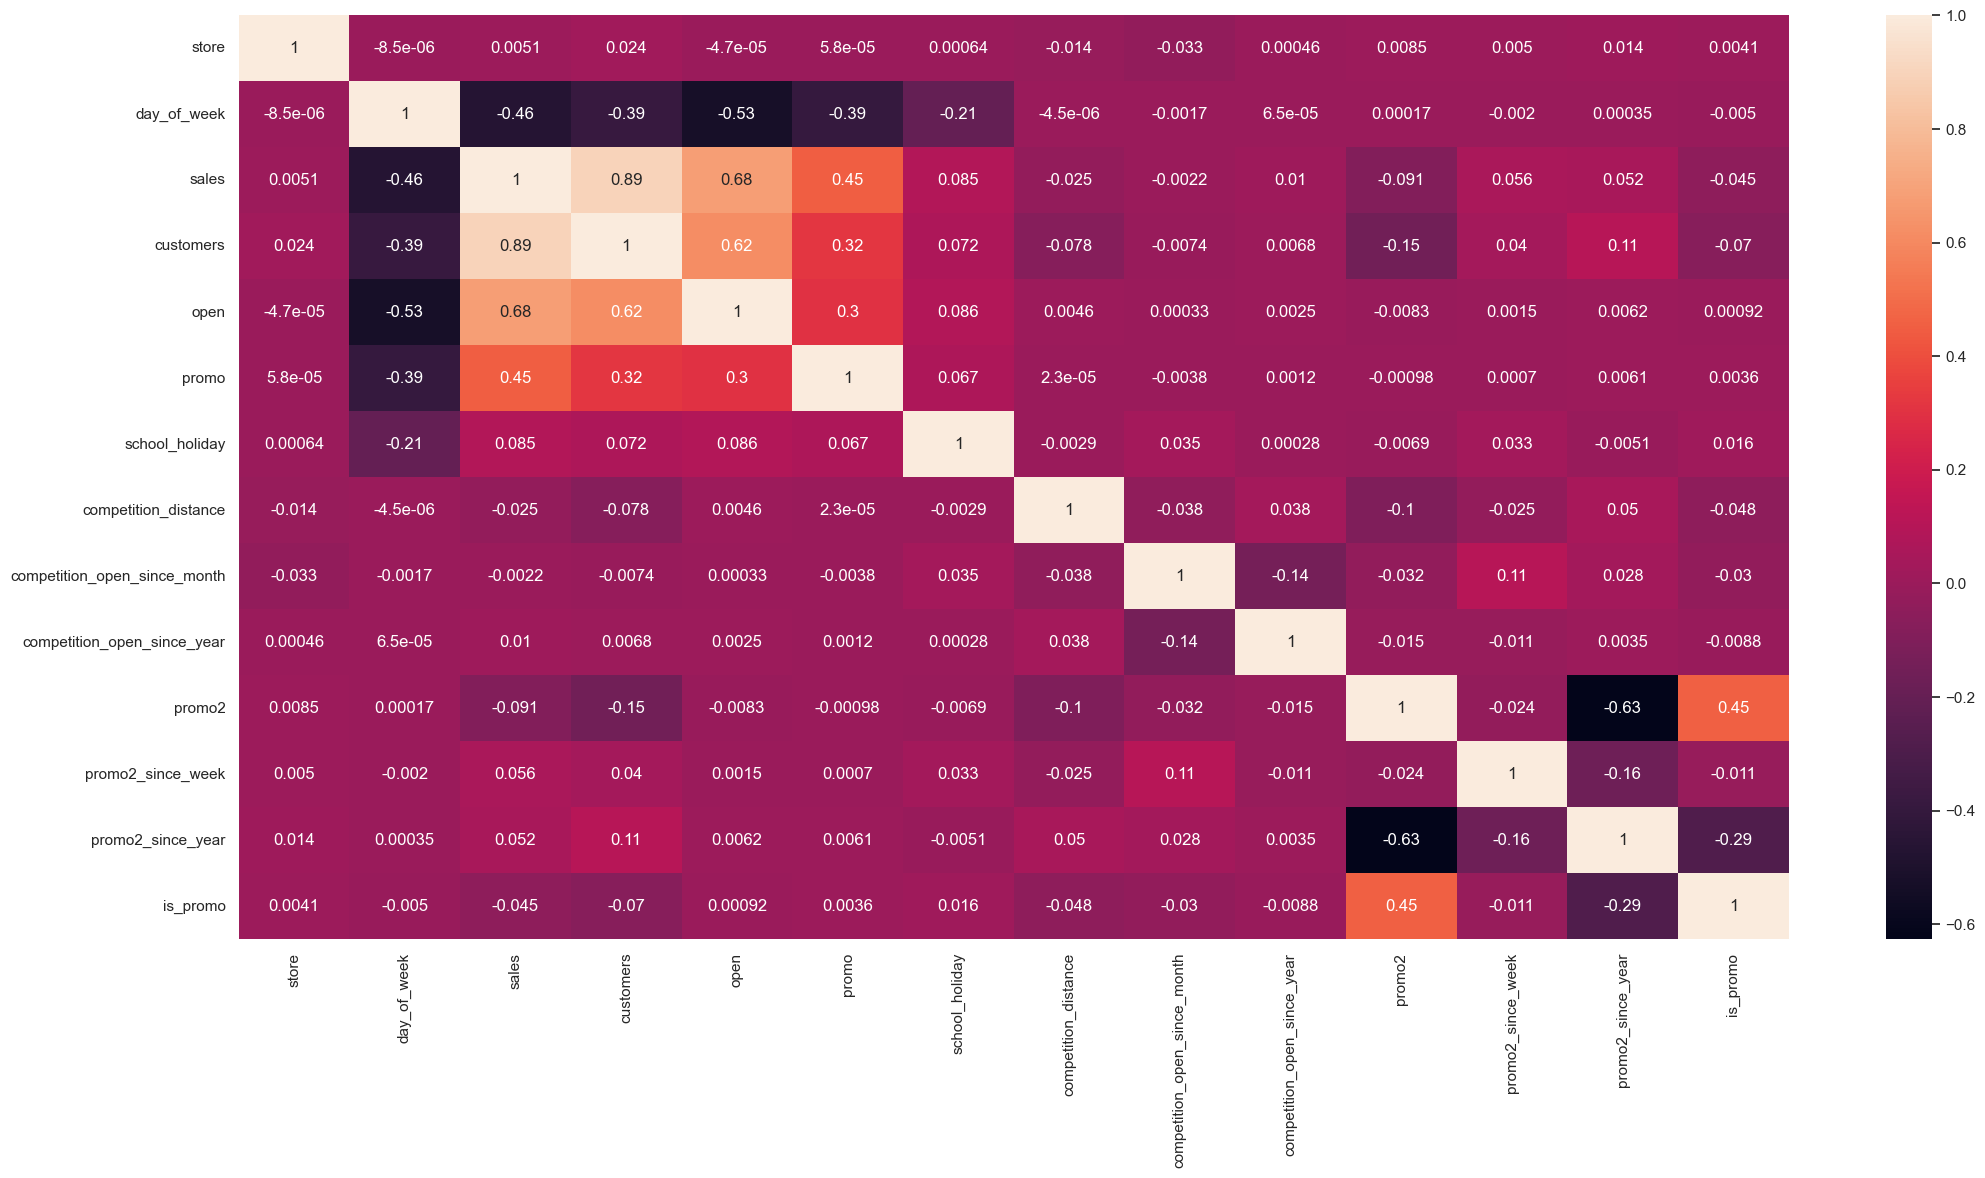

In [68]:
correlation = num_attributes.corr (method = 'pearson')
sns.heatmap (correlation, annot=True)

In [69]:
# <notion> 
# df.corr (method = 'pearson') - para plotar tabela de correlacoes
#     correlation = num_attributes.corr (method = 'pearson')
#     - sns.heatmap (correlation, annot=True) - plota mapa de correlacoes
     

SyntaxError: invalid syntax (3603742769.py, line 2)

### Categorical attributes

<AxesSubplot:>

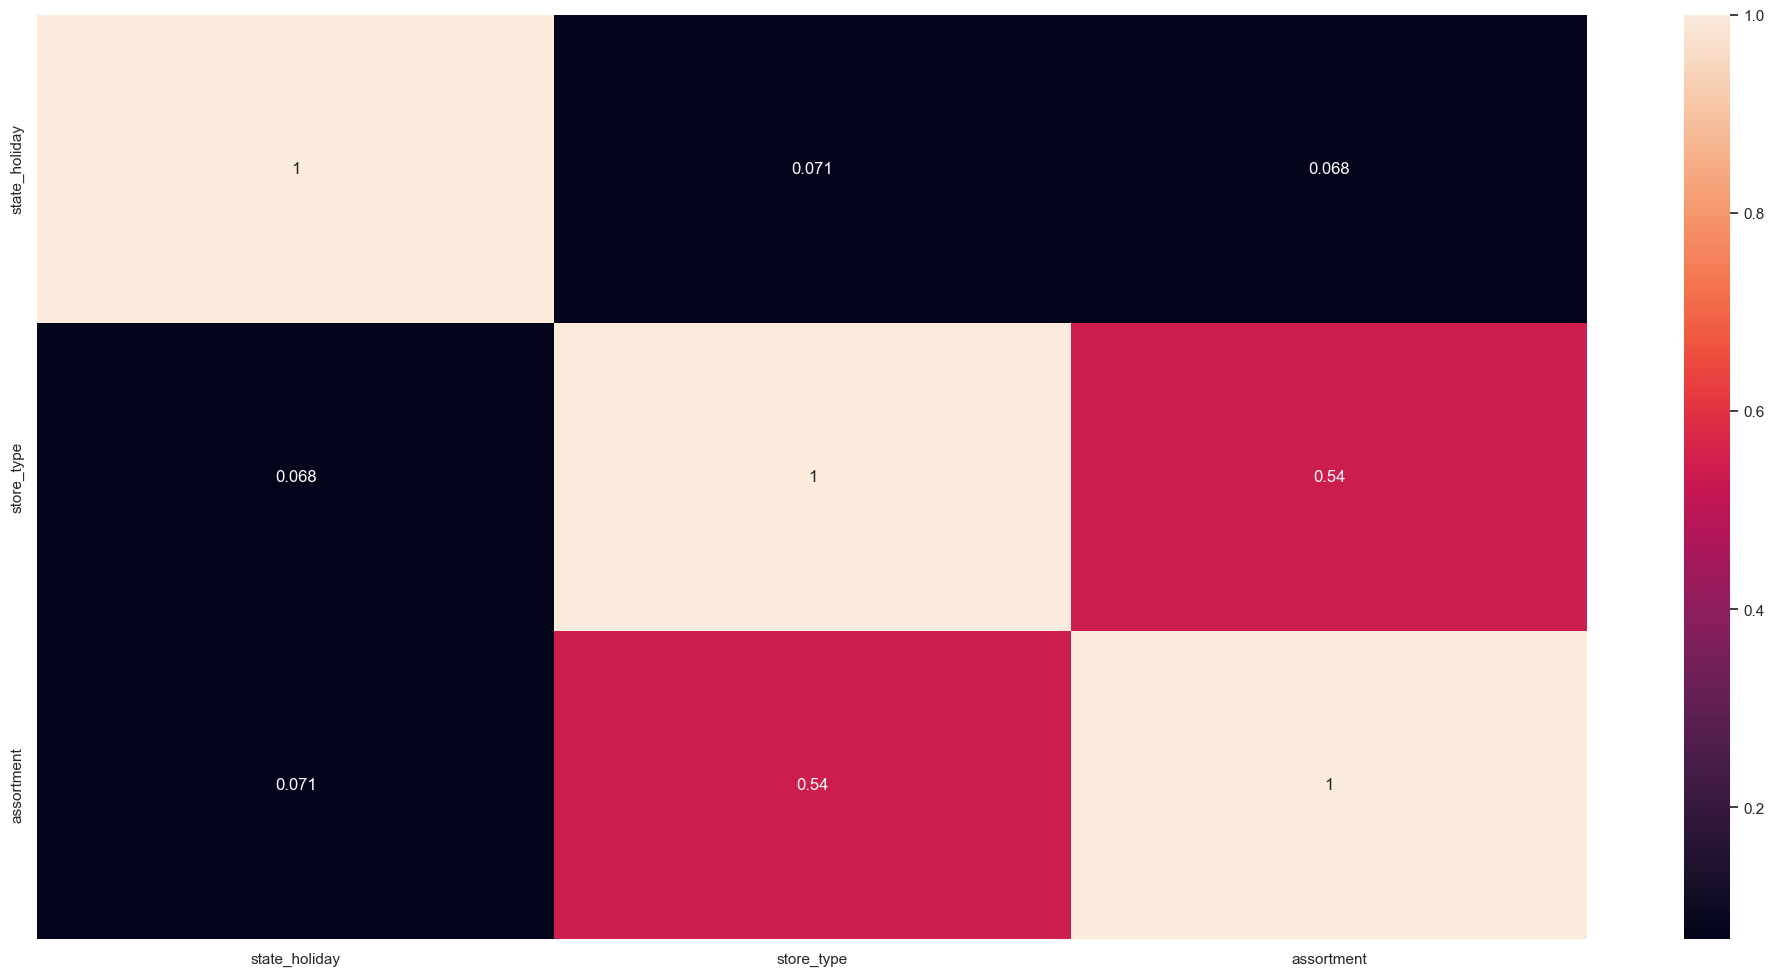

In [70]:
#only cattegorical data 
a = df4.select_dtypes ( include = ['object'] )

# calculate cramer v
a1 = cramer_v (a['state_holiday'], a['state_holiday'])
a2 = cramer_v (a['state_holiday'], a['assortment'])
a3 = cramer_v (a['state_holiday'], a['store_type'])

a4 = cramer_v (a['store_type'], a['state_holiday'])
a5 = cramer_v (a['store_type'], a['store_type'])
a6 = cramer_v (a['store_type'], a['assortment'])


a7 = cramer_v (a['assortment'], a['state_holiday'])
a8 = cramer_v (a['assortment'], a['store_type'])
a9 = cramer_v (a['assortment'], a['assortment'])

#final dataset
d = pd.DataFrame ({'state_holiday': [a1, a2, a3],
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9] })

d = d.set_index(d.columns)

sns.heatmap (d , annot=True)

In [ ]:
# <notion> 

# - from scipy import stats - biblioteca scipy com stats para calcular o chi2

# - pd.crosstab - metodo para plotar matriz de confusao
#     cm = pd.crosstab (a['state_holiday'], a['store_type'] )
    
# chi2 = ss.chi2_contingency (cm) - para calcular o chi2
#     out:
#         (12792.159524019908, -> resultado do teste baseado no pearson
#          0.0,                -> p valor
#          9,                  -> grau de liberdade
#          array([[3.84324548e+01, 1.30843335e+00, 9.49942795e+00, 2.17596839e+01], -> tabela de frequencia
#                 [7.84888161e+01, 2.67215262e+00, 1.94002402e+01, 4.44387911e+01],
#                 [3.75663713e+02, 1.27894753e+01, 9.28535634e+01, 2.12693248e+02],
#                 [4.56549415e+05, 1.55432299e+04, 1.12846247e+05, 2.58489108e+05]]))

# v crammer - np.sqrt( (chi2corr/n) / ( min (kcorr-1, rcorr-1 )))
#     - ver o notebook a funcao criada


# PREPARACAO DOS DADOS

In [154]:
df5 = df4.copy()

## Normalizacao

Metodo util para dados com distribuicao gaussiana, normalizada. Por isso, ao verificar a distribuicao das variaveis numericas, e feito a analise univariada das mesmas, nao se verificou nenhuma que tivesse uma distribuicao desse tipo.

Assim, é **mais seguro** nao utilizar o metodo de normalizacao sobre esses dados

## Rescaling

In [155]:
rs = RobustScaler (unit_variance = True)
# instanciando 'rs' com RobustScaler() - sera usado esse metodo para variaveis com muitos outliers
mms = MinMaxScaler () 
# instanciando 'mms' com MinMaxScaler() - sera usado para variaveis com outliers pouco relevantes

# competition_distance
df5['competition_distance'] = rs.fit_transform ( df5[['competition_distance']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )

# competition_time_month
df5 ['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values ) 

# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

In [156]:
# <notion>

# from sklearn.preprocessing import RobustScaler - modulo de scikit learn que contem Robust Scaler

# RobustScaler - metodo para aplicar robust scaler

# rs.fit_transform () - metodo que encontra os parametros de rs (os quartis no caso) e ja aplica a formula de robust scaler
    # df5 ['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values ) 


In [157]:
###### PASSOS PARA APLICAR RESCALING DOS DADOS ###### 

# 1. Identificar sobre quais variaveis aplicar o rescaling
# a = df5.select_dtypes ( include = ['int64', 'float64'])


# 2. Separar apenas aquelas que nao tem uma natureza ciclica (essas vao para "transformacao")
# competition_distance
# year
# competition_time_month
# promo_time_week


# 3. Definir o metodo Rescaling (min-max ou robust), analisando se a variavel tem ou nao outliers com o metodo sns.boxplot
# sns.boxplot (df5['promo_time_week'])



## Transformacao 

### Encodings


In [158]:
# state_holiday - One hot encoding
df5 =  pd.get_dummies(df5, prefix=['state_holiday'] ,columns = ['state_holiday'])

# store_type = Label encoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### Response Variable Transformation

In [159]:
df5['sales'] = np.log1p(df5['sales'])

<AxesSubplot:xlabel='sales', ylabel='Count'>

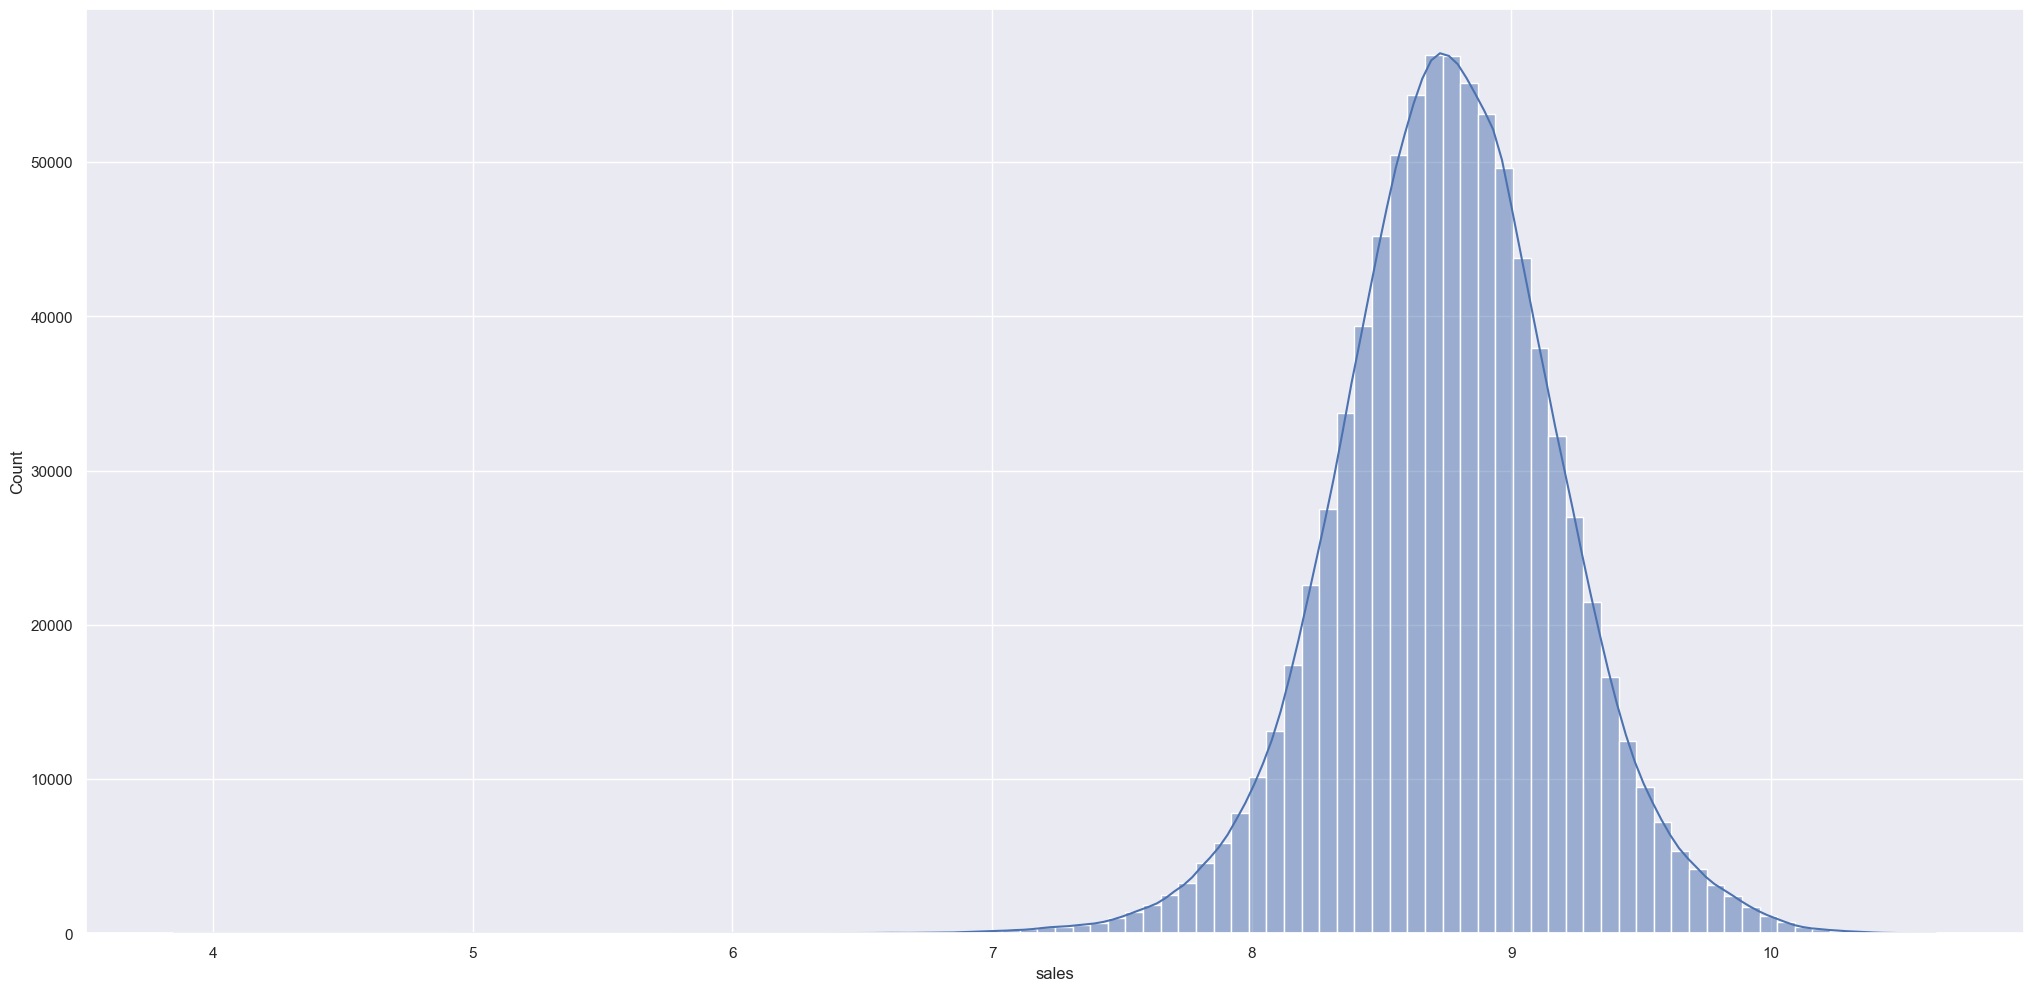

In [160]:
sns.histplot (df5['sales'],bins = 100, kde=True)

### nature transformation 

In [161]:
# month 
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2 * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2 * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2 * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x *  ( 2 * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2 * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2 * np.pi/52 ) ) )

# day of week 
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2 * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2 * np.pi/7 ) ) )



In [162]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.230632,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.382936,11,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,2.567413,12,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.372057,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,6.000783,4,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


In [ ]:
# <notion>

# from sklearn.preprocessing import LabelEncoder 

# ONE HOT ENCODING
# pd.get_dummies ()- metodo para fazer one hot encoding
#     df5 =  pd.get_dummies(df5, prefix=['state_holiday'] ,columns = ['state_holiday'])

# LABEL ENCODING
# store_type = Label encoder
#     le = LabelEncoder()
#     df5['store_type'] = le.fit_transform(df5['store_type'])
    
# ORDINAL ENCODING
#     assortment_dict = {'basic': 1, 'extra':2, 'extended':3}
#     df5['assortment'] = df5['assortment'].map(assortment_dict)

In [ ]:
# TRANSFORMACAO DE NATUREZA CICLICA
# # day of week 
# df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2 * np.pi/7 ) ) )
# df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2 * np.pi/7 ) ) )